<a href="https://colab.research.google.com/github/mcagriaksoy/EuroSAT-Image-Classification-with-Wide-and-Deep-Learning/blob/main/Paper_EuroSAT_Wide%26DeepLearning_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi, welcome to my research of wide and deep learning :)

I would like to special thanks to my professeurs and supporters.

Beril Sirmacek b.sirmacek@saxion.nl
Cem Unsalan cem.unsalan@marmara.edu.tr



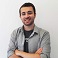

2021 - Created By Mehmet Çağrı Aksoy (Software Engineer)

https://orcid.org/0000-0002-7886-7945

https://www.researchgate.net/profile/Mehmet-Aksoy-12

https://github.com/mcagriaksoy

https://www.linkedin.com/in/mcagriaksoy/

https://scholar.google.com/citations?user=CKRkg1EAAAAJ&hl=en&oi=ao

# Dataset Preparation 
This will connect to my drive and copy the contents from my related drive path.
The dataset is gathered from Kaggle: https://www.kaggle.com/apollo2506/eurosat-dataset


> This dataset is being used for classifying the use of land in geospatial images. The end goal for the classification is that the top 2 uses of land in an image are given as output to the user.

> This dataset contains images belonging to the EuroSat dataset. It contains RGB images collected from the Sentinel Dataset.


It has 10 classes that represents the field of:

    AnnualCrop
    Forest
    HerbaceousVegatation
    Highway
    Industrial
    Pasture
    PermanentCrop
    Residential
    River
    SeaLake

Each image is 64x64 pixels with a Ground Sampling Distance of 10m. They were all collected from the Sentinel-2 satellite. But we are resized them to 32x32 to less training time requirements.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/Thesis_Dataset/EuroSAT.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: archive (1)/2750/River/River_1451.jpg  
  inflating: archive (1)/2750/River/River_1452.jpg  
  inflating: archive (1)/2750/River/River_1453.jpg  
  inflating: archive (1)/2750/River/River_1454.jpg  
  inflating: archive (1)/2750/River/River_1455.jpg  
  inflating: archive (1)/2750/River/River_1456.jpg  
  inflating: archive (1)/2750/River/River_1457.jpg  
  inflating: archive (1)/2750/River/River_1458.jpg  
  inflating: archive (1)/2750/River/River_1459.jpg  
  inflating: archive (1)/2750/River/River_146.jpg  
  inflating: archive (1)/2750/River/River_1460.jpg  
  inflating: archive (1)/2750/River/River_1461.jpg  
  inflating: archive (1)/2750/River/River_1462.jpg  
  inflating: archive (1)/2750/River/River_1463.jpg  
  inflating: archive (1)/2750/River/River_1464.jpg  
  inflating: archive (1)/2750/River/River_1465.jpg  
  inflating: archive (1)/2750/River/River_1466.jpg  
  inflating: archive (1)/2750/River/River_1467.jpg  


# Library Calls
Required Libraries need to be called.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We'll build the CNN as a sequence of layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [4]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# Definitions
Research, model related definitions.

In [5]:
CLASS_NUMBER = 10
channels = 3
img_height = 32
img_width = 32
epochs = 20
batch_size = 64

input_shape = (img_height,img_width,channels)

# Data Gathering
In this step, the data will be gathered and processed (making ready) for the cnn model feeding.
Our dataset has the json file that describes the classes of each image and with this info we classify them on. We also resize whole dataset as 32x32 which is minimum acceptable resolution for many famous models.

In [6]:
import pandas as pd  

traindf=pd.read_csv(r'/content/train (1).csv')
testdf=pd.read_csv(r'/content/test (1).csv')
validdf=pd.read_csv(r'/content/validation.csv')

df=pd.concat([traindf, testdf, validdf],  axis=0).reset_index(drop=True)

In [7]:
def load_data(im_file_names, im_sizes):
    imgs=[]
    for fname in im_file_names :
        arr=Image.open(fname)
        arr = arr.resize(im_sizes)    
        arr=np.array(arr)/255
        imgs.append(arr)
    return np.array(imgs)


In [8]:
labels = np.array(df.Label)
#Each image is 64x64 pixels with a Ground Sampling Distance of 10m. We will resize them to 32x32!
images=load_data('/content/archive (1)/2750/'+df.Filename,(img_height,img_width))
images.shape

(27000, 32, 32, 3)

# Data Preprocessing
Train and test data will be divided in here.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.20)

In [10]:
del images
del labels

Grab planes data, then append the ships data

In [11]:
x_train.shape

(21600, 32, 32, 3)

In [12]:
# We need to expand the labels to look like multiple-output nodes! 
# So if the category was 3, then the 3rd node would have a 1 in it!
y_train = tf.keras.utils.to_categorical( y_train, CLASS_NUMBER )
y_test = tf.keras.utils.to_categorical( y_test,  CLASS_NUMBER )

# **Feature Extraction Steps for Wide Inputs**

---
Due to lack of parallel algorithms, the creating wide features take some time. Please wait..



## GLCM Features

In [13]:
#GLCM Properties Definitions
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte

# GLCM properties
def contrast_feature(matrix_coocurrence):
	contrast = greycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = greycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = greycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = greycoprops(matrix_coocurrence, 'ASM')
	return asm

bins32 = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160,
            168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit

In [14]:
# Calculating the GLCM Properties !!

from skimage.feature import greycomatrix, greycoprops
from skimage import data
from skimage import util, exposure, data
import pywt
from skimage import io
from skimage.color import rgb2gray

lenx = x_train.shape[0]
X_homoTRAIN = np.zeros((lenx, 4))
X_correlationTRAIN = np.zeros((lenx, 4))
X_dissimilarityTRAIN = np.zeros((lenx, 4))
X_contrastTRAIN = np.zeros((lenx, 4))
X_energyTRAIN = np.zeros((lenx, 4))

for i in range(lenx):
    image32 = x_train[i]
    image32 = rgb2gray(image32)
    np.clip(image32, 0, 255, out=image32)
    image = image32.astype('uint8')
    inds = np.digitize(image, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_correlationTRAIN[i] = correlation_feature(matrix_coocurrence)
    X_homoTRAIN[i] = homogeneity_feature(matrix_coocurrence)
    X_contrastTRAIN[i] = contrast_feature(matrix_coocurrence)
    X_dissimilarityTRAIN[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTRAIN[i] = energy_feature(matrix_coocurrence)

len2 = x_test.shape[0]
X_homoTEST = np.zeros((len2, 4))
X_correlationTEST = np.zeros((len2, 4))
X_dissimilarityTEST = np.zeros((len2, 4))
X_contrastTEST = np.zeros((len2, 4))
X_energyTEST = np.zeros((len2, 4))

for i in range(len2):
    image32 = x_test[i]
    image32 = rgb2gray(image32)
    np.clip(image32, 0, 255, out=image32)
    image = image32.astype('uint8')
    inds = np.digitize(image, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_contrastTEST[i] = contrast_feature(matrix_coocurrence)
    X_correlationTEST[i] = correlation_feature(matrix_coocurrence)
    X_homoTEST[i] = homogeneity_feature(matrix_coocurrence)
    X_dissimilarityTEST[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTEST[i] = energy_feature(matrix_coocurrence)


In [15]:
x_train_glcm = np.concatenate((X_correlationTRAIN, X_correlationTRAIN, X_homoTRAIN, X_dissimilarityTRAIN, X_energyTRAIN), axis=1)
x_test_glcm = np.concatenate((X_contrastTEST, X_correlationTEST, X_homoTEST, X_dissimilarityTEST, X_energyTEST), axis=1)

In [16]:
x_train_glcm.shape

(21600, 20)

## Mean Value

In [17]:
#Calculating mean values for wide inputs
from sklearn.preprocessing import normalize

x_train_mean = x_train.mean(axis=1).mean(axis=1)
x_test_mean = x_test.mean(axis=1).mean(axis=1)
x_train_mean = normalize(x_train_mean, axis=1, norm='l1')
x_test_mean = normalize(x_test_mean, axis=1, norm='l1')

In [18]:
import cv2
#plt.imshow(image)

lenx = x_train.shape[0]
x_train_sobel_y = np.zeros((lenx, 32,32))
x_train_sobel_x = np.zeros((lenx, 32,32))


for i in range(lenx):
  image = rgb2gray(x_train[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_train_sobel_y[i] = grad_y
  x_train_sobel_x[i] = grad_x

x_test_sobel_y = np.zeros((lenx, 32,32))
x_test_sobel_x = np.zeros((lenx, 32,32))

lenx = x_test.shape[0]
for i in range(lenx):
  image = rgb2gray(x_test[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_test_sobel_y[i] = grad_y
  x_test_sobel_x[i] = grad_x


## Hu - Zernike Moments

In [19]:
import cv2
def hu_moments(image):
    image = rgb2gray(image)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [20]:
lenx = x_train.shape[0]
x_train_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_train_HU[NUM] = hu_moments(x_train[NUM])

lenx = x_test.shape[0]
x_test_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_test_HU[NUM] = hu_moments(x_test[NUM])

In [21]:
x_train_HU = normalize(x_train_HU, axis=1, norm='l1')
x_test_HU = normalize(x_test_HU, axis=1, norm='l1')

## Local Binary Patterns

In [22]:
#https://github.com/arsho/local_binary_patterns

In [23]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):  
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

In [24]:
# Function to generate horizontal projection profile
def getHorizontalProjectionProfile(image):
    # Convert black spots to ones
    image[image == 0]   = 1
    # Convert white spots to zeros
    image[image == 255] = 0
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection

# Function to generate vertical projection profile
def getVerticalProjectionProfile(image):
    # Convert black spots to ones 
    image[image == 0]   = 1
    # Convert white spots to zeros 
    image[image == 255] = 0
    vertical_projection = np.sum(image, axis = 0)
    return vertical_projection


In [25]:
lenx = x_train.shape[0]
x_train_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_train[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_train_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)
    
lenx = x_test.shape[0]
x_test_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_test[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_test_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)

In [26]:
from sklearn import preprocessing

lenx = x_train.shape[0]
x_train_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_lbp[NUM])
  x_train_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_lbp_vector[NUM] = normalize(x_train_lbp_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_lbp[NUM])
  x_test_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_lbp_vector[NUM] = normalize(x_test_lbp_vector[NUM].reshape(1, -1))

In [27]:
x_train.shape

(21600, 32, 32, 3)

## Histogram of Oriented Gradients

In [28]:

from skimage.feature import hog
from skimage import data, exposure

lenx = x_train.shape[0]
x_train_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_train_hog[NUM] = hog(x_train[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

lenx = x_test.shape[0]
x_test_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_test_hog[NUM] = hog(x_test[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

In [29]:
x_train_hog.shape

(21600, 32, 32)

In [30]:
lenx = x_train.shape[0]
x_train_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_hog[NUM])
  x_train_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_hog_vector[NUM] = normalize(x_train_hog_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_hog[NUM])
  x_test_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_hog_vector[NUM] = normalize(x_test_hog_vector[NUM].reshape(1, -1))

## Color Invariants (RGB)

In [31]:
import PIL
import math

def invariant_r(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (r/max(g,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_g(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (g/max(r,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_b(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (b/max(r,g))
      c1[i][j]= math.atan(x)
  return c1

In [32]:
lenx = x_train.shape[0]
r_train = []
g_train = []
b_train = []

for NUM in range(lenx):
  r_train_tmp = invariant_r(x_train[NUM])
  g_train_tmp = invariant_g(x_train[NUM])
  b_train_tmp = invariant_b(x_train[NUM])

  r_train.append(r_train_tmp)
  g_train.append(g_train_tmp)
  b_train.append(b_train_tmp)

lenx = x_test.shape[0]
r_test = []
g_test = []
b_test = []

for NUM in range(lenx):
  r_test_tmp = invariant_r(x_test[NUM])
  g_test_tmp = invariant_g(x_test[NUM])
  b_test_tmp = invariant_b(x_test[NUM])

  r_test.append(r_test_tmp)
  g_test.append(g_test_tmp)
  b_test.append(b_test_tmp)


r_train = np.array(r_train)
g_train = np.array(g_train)
b_train = np.array(b_train)

r_test = np.array(r_test)
g_test = np.array(g_test)
b_test = np.array(b_test)


In [33]:
lenx = x_train.shape[0]
x_train_invariant_Red = np.zeros((lenx, 64))
x_train_invariant_Green = np.zeros((lenx, 64))
x_train_invariant_Blue = np.zeros((lenx, 64))


for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_train[NUM])
  vertical_projection = getVerticalProjectionProfile(r_train[NUM])
  x_train_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Red[NUM] = normalize(x_train_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_train[NUM])
  vertical_projection = getVerticalProjectionProfile(g_train[NUM])
  x_train_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Green[NUM] = normalize(x_train_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_train[NUM])
  vertical_projection = getVerticalProjectionProfile(b_train[NUM])
  x_train_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Blue[NUM] = normalize(x_train_invariant_Blue[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_invariant_Red = np.zeros((lenx, 64))
x_test_invariant_Green = np.zeros((lenx, 64))
x_test_invariant_Blue = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_test[NUM])
  vertical_projection = getVerticalProjectionProfile(r_test[NUM])
  x_test_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Red[NUM] = normalize(x_test_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_test[NUM])
  vertical_projection = getVerticalProjectionProfile(g_test[NUM])
  x_test_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Green[NUM] = normalize(x_test_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_test[NUM])
  vertical_projection = getVerticalProjectionProfile(b_test[NUM])
  x_test_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Blue[NUM] = normalize(x_test_invariant_Blue[NUM].reshape(1, -1))

# **Grad-CAM Results**



---



In [73]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [180]:
MODEL = xx_model
TEST_PATH = '/content/archive (1)/2750/SeaLake/SeaLake_103.jpg'

In [181]:
image = cv2.imread(TEST_PATH)
image = cv2.resize(image, (32, 32))
#image = x_test[88]
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = MODEL.predict(image) 
i = np.argmax(preds[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [182]:
for idx in range(len(MODEL.layers)):
  print(MODEL.get_layer(index = idx).name)


input_9
efficientnetb0
global_average_pooling2d_4
dense_3
dense_4
dense_5


In [187]:
icam = GradCAM(MODEL, i, 'block5c_project_con') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

image = cv2.imread(TEST_PATH)
image = cv2.resize(image, (32, 32))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

ValueError: ignored

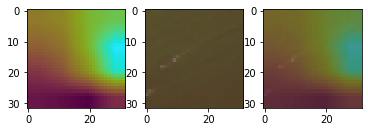

In [179]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# **Custom Created Sequential CNN Experiments**



---



# **1st Model Experiments**

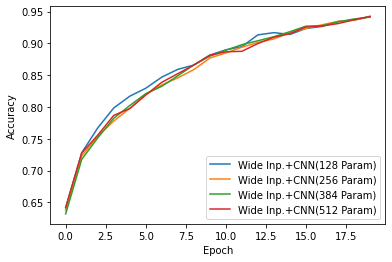

## Sequential Custom CNN Solution Only
- 20 Epochs
- 3 Dense Layers before softmax.
- Max Accuracy is 0.9678




In [97]:
model = tf.keras.Sequential([
                              
    layers.Input(shape=input_shape),
    #layers.experimental.preprocessing.RandomFlip("horizontal"),
    #layers.experimental.preprocessing.RandomRotation(0.1),
    #layers.experimental.preprocessing.RandomContrast(0.25),
    #Conv Layer 1
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 2
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 3
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    
    layers.Dense(units=CLASS_NUMBER, activation='softmax')
])
# Choose the 'Adam' optimizer for Stochastic Gradient Descent
# https://arxiv.org/pdf/1609.04747.pdf
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_9 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
history_cnn = model.fit( x_train,
                         y_train,
                         validation_data=(x_test,y_test),
                         epochs=epochs, 
                         batch_size = batch_size,
                         #callbacks = [reduce_lr]
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 17s 49ms/step - loss: 0.8977 - accuracy: 0.6758 - val_loss: 4.1754 - val_accuracy: 0.2069
Epoch 2/20
338/338 [==============================] - 16s 48ms/step - loss: 0.6376 - accuracy: 0.7725 - val_loss: 3.7968 - val_accuracy: 0.3207
Epoch 3/20
338/338 [==============================] - 16s 48ms/step - loss: 0.5471 - accuracy: 0.8070 - val_loss: 1.9623 - val_accuracy: 0.4711
Epoch 4/20
338/338 [==============================] - 15s 44ms/step - loss: 0.4618 - accuracy: 0.8342 - val_loss: 4.0000 - val_accuracy: 0.3461
Epoch 5/20
338/338 [==============================] - 16s 47ms/step - loss: 0.4078 - accuracy: 0.8554 - val_loss: 0.7984 - val_accuracy: 0.7269
Epoch 6/20
338/338 [==============================] - 15s 44ms/step - loss: 0.3387 - accuracy: 0.8786 - val_loss: 3.2206 - val_accuracy: 0.3637
Epoch 7/20
338/338 [==============================] - 16s 48ms/step - loss: 0.3112 - accuracy: 0.8879 - val_loss: 1.4268 - val_accuracy:

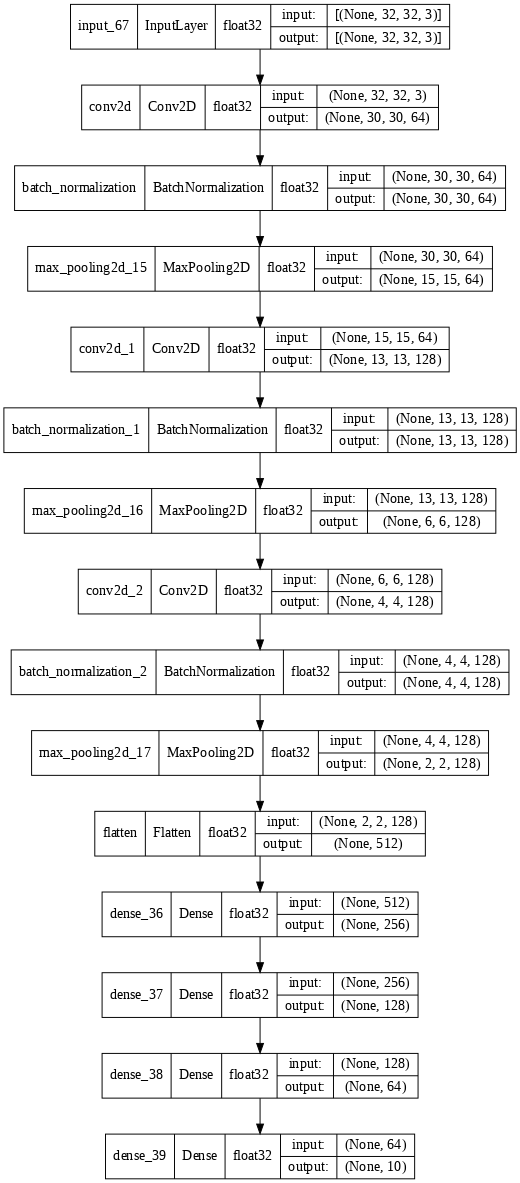

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

## Sequential Custom CNN Solution + Wide Inputs
- 20 Epochs
- 3 Dense Layers before softmax.





### 512 Deep Input + 350 Wide Input
- Max Accuracy is 0.9425


In [ ]:
layers = tf.keras.layers

wide512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide512_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_94[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_24[0][0]']       
                                                                                                  
 batch_normalization_10 (BatchN  (None, 14, 14, 128)  512        ['conv2d_10[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_512 = wide512_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             batch_size = batch_size,
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 15s 44ms/step - loss: 0.9974 - accuracy: 0.6420 - val_loss: 4.4889 - val_accuracy: 0.1156
Epoch 2/20
338/338 [==============================] - 15s 45ms/step - loss: 0.7581 - accuracy: 0.7276 - val_loss: 5.6954 - val_accuracy: 0.2270
Epoch 3/20
338/338 [==============================] - 16s 47ms/step - loss: 0.6802 - accuracy: 0.7557 - val_loss: 0.8936 - val_accuracy: 0.6744
Epoch 4/20
338/338 [==============================] - 16s 48ms/step - loss: 0.5978 - accuracy: 0.7869 - val_loss: 2.6138 - val_accuracy: 0.4583
Epoch 5/20
338/338 [==============================] - 15s 44ms/step - loss: 0.5502 - accuracy: 0.7975 - val_loss: 1.6378 - val_accuracy: 0.5780
Epoch 6/20
338/338 [==============================] - 15s 45ms/step - loss: 0.4998 - accuracy: 0.8189 - val_loss: 1.2813 - val_accuracy: 0.6426
Epoch 7/20
338/338 [==============================] - 14s 42ms/step - loss: 0.4524 - accuracy: 0.8389 - val_loss: 0.9105 - val_accuracy:

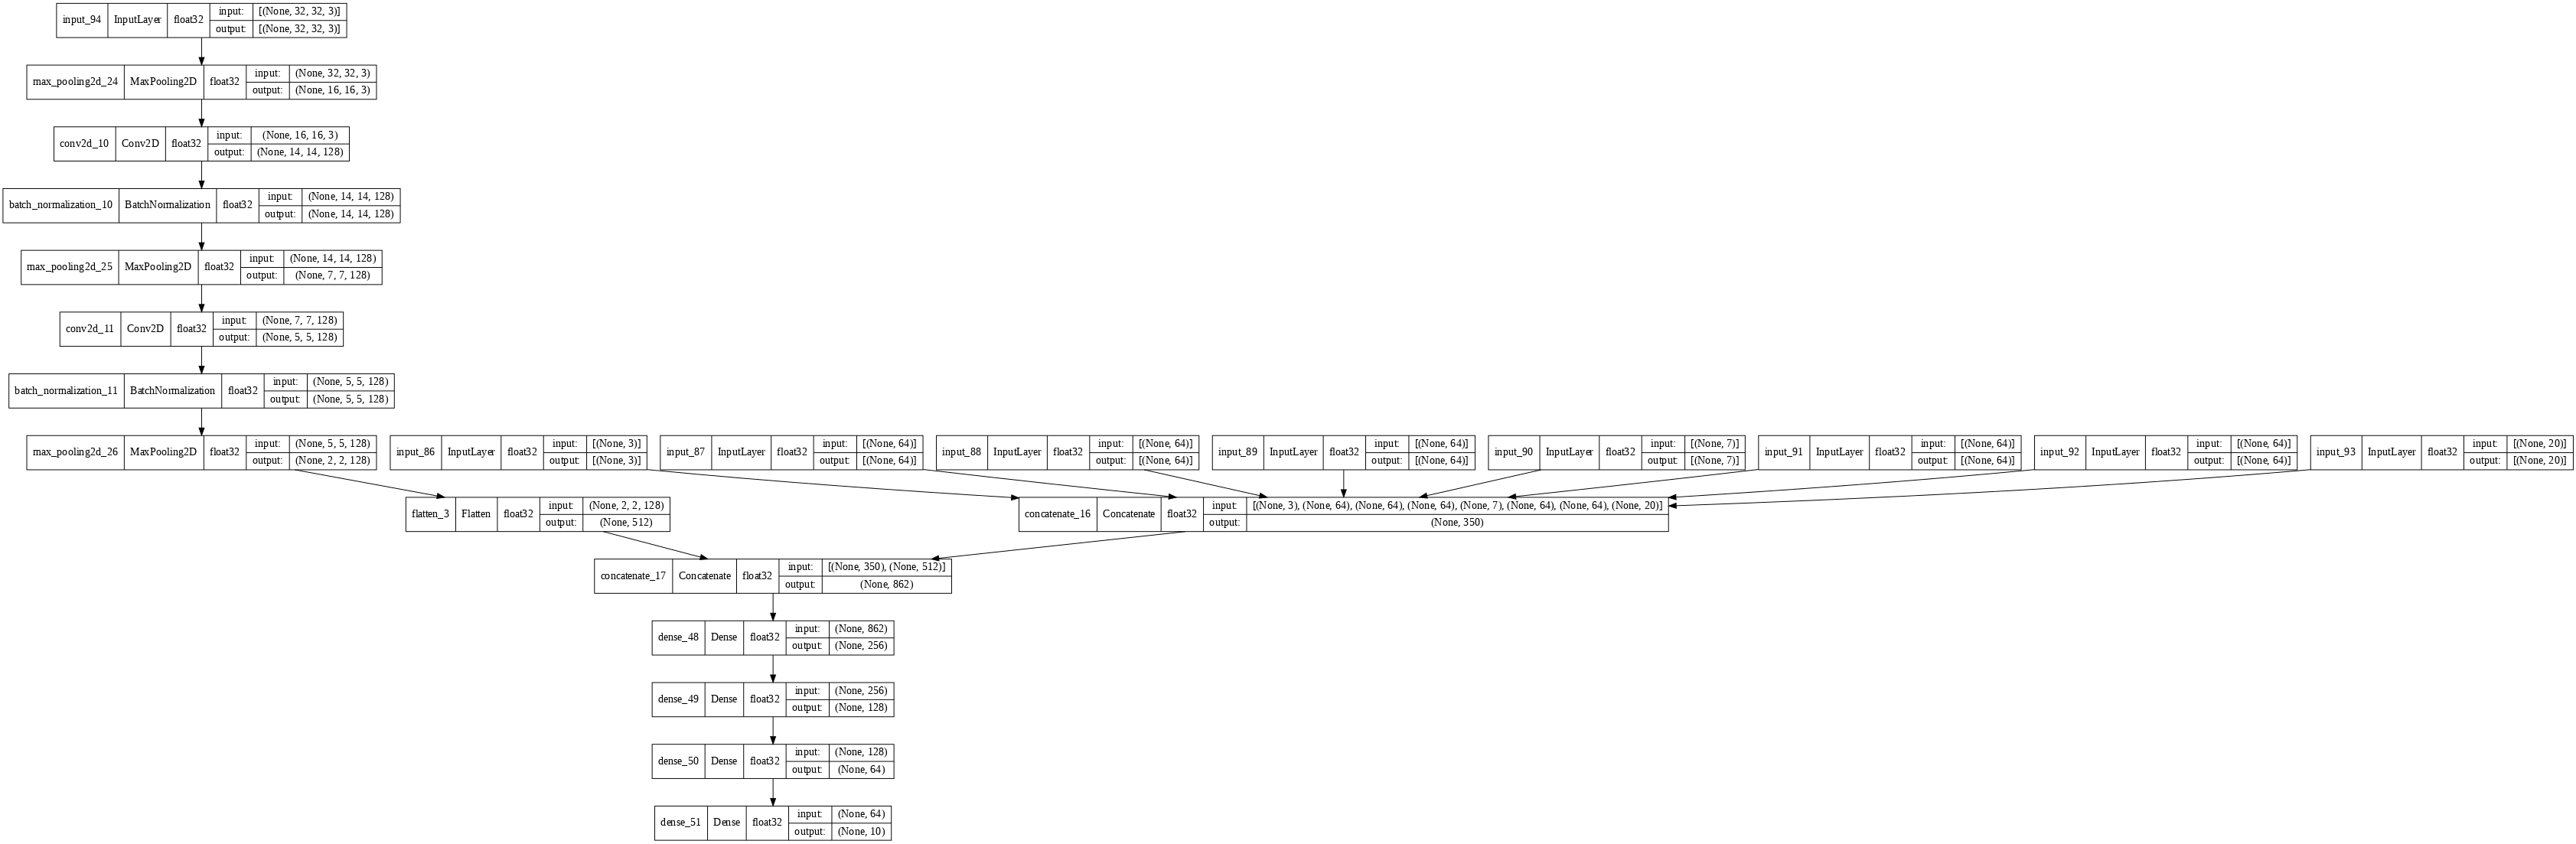

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

### 384 Deep Input + 350 Wide Input
- Max Accuracy is 0.9417

In [ ]:
layers = tf.keras.layers

wide384_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=384, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide384_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide384_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide384_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_103 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_27 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_103[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_27[0][0]']       
                                                                                                  
 batch_normalization_13 (BatchN  (None, 14, 14, 128)  512        ['conv2d_13[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_384 = wide384_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             batch_size = batch_size,
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 15s 45ms/step - loss: 1.0180 - accuracy: 0.6319 - val_loss: 4.9686 - val_accuracy: 0.1798
Epoch 2/20
338/338 [==============================] - 15s 45ms/step - loss: 0.7799 - accuracy: 0.7176 - val_loss: 2.9907 - val_accuracy: 0.2889
Epoch 3/20
338/338 [==============================] - 16s 48ms/step - loss: 0.6946 - accuracy: 0.7514 - val_loss: 5.1513 - val_accuracy: 0.2646
Epoch 4/20
338/338 [==============================] - 16s 48ms/step - loss: 0.6063 - accuracy: 0.7824 - val_loss: 1.3924 - val_accuracy: 0.5787
Epoch 5/20
338/338 [==============================] - 15s 45ms/step - loss: 0.5585 - accuracy: 0.8023 - val_loss: 1.0375 - val_accuracy: 0.6735
Epoch 6/20
338/338 [==============================] - 16s 47ms/step - loss: 0.5031 - accuracy: 0.8210 - val_loss: 1.4302 - val_accuracy: 0.5730
Epoch 7/20
338/338 [==============================] - 16s 48ms/step - loss: 0.4677 - accuracy: 0.8326 - val_loss: 1.1417 - val_accuracy:

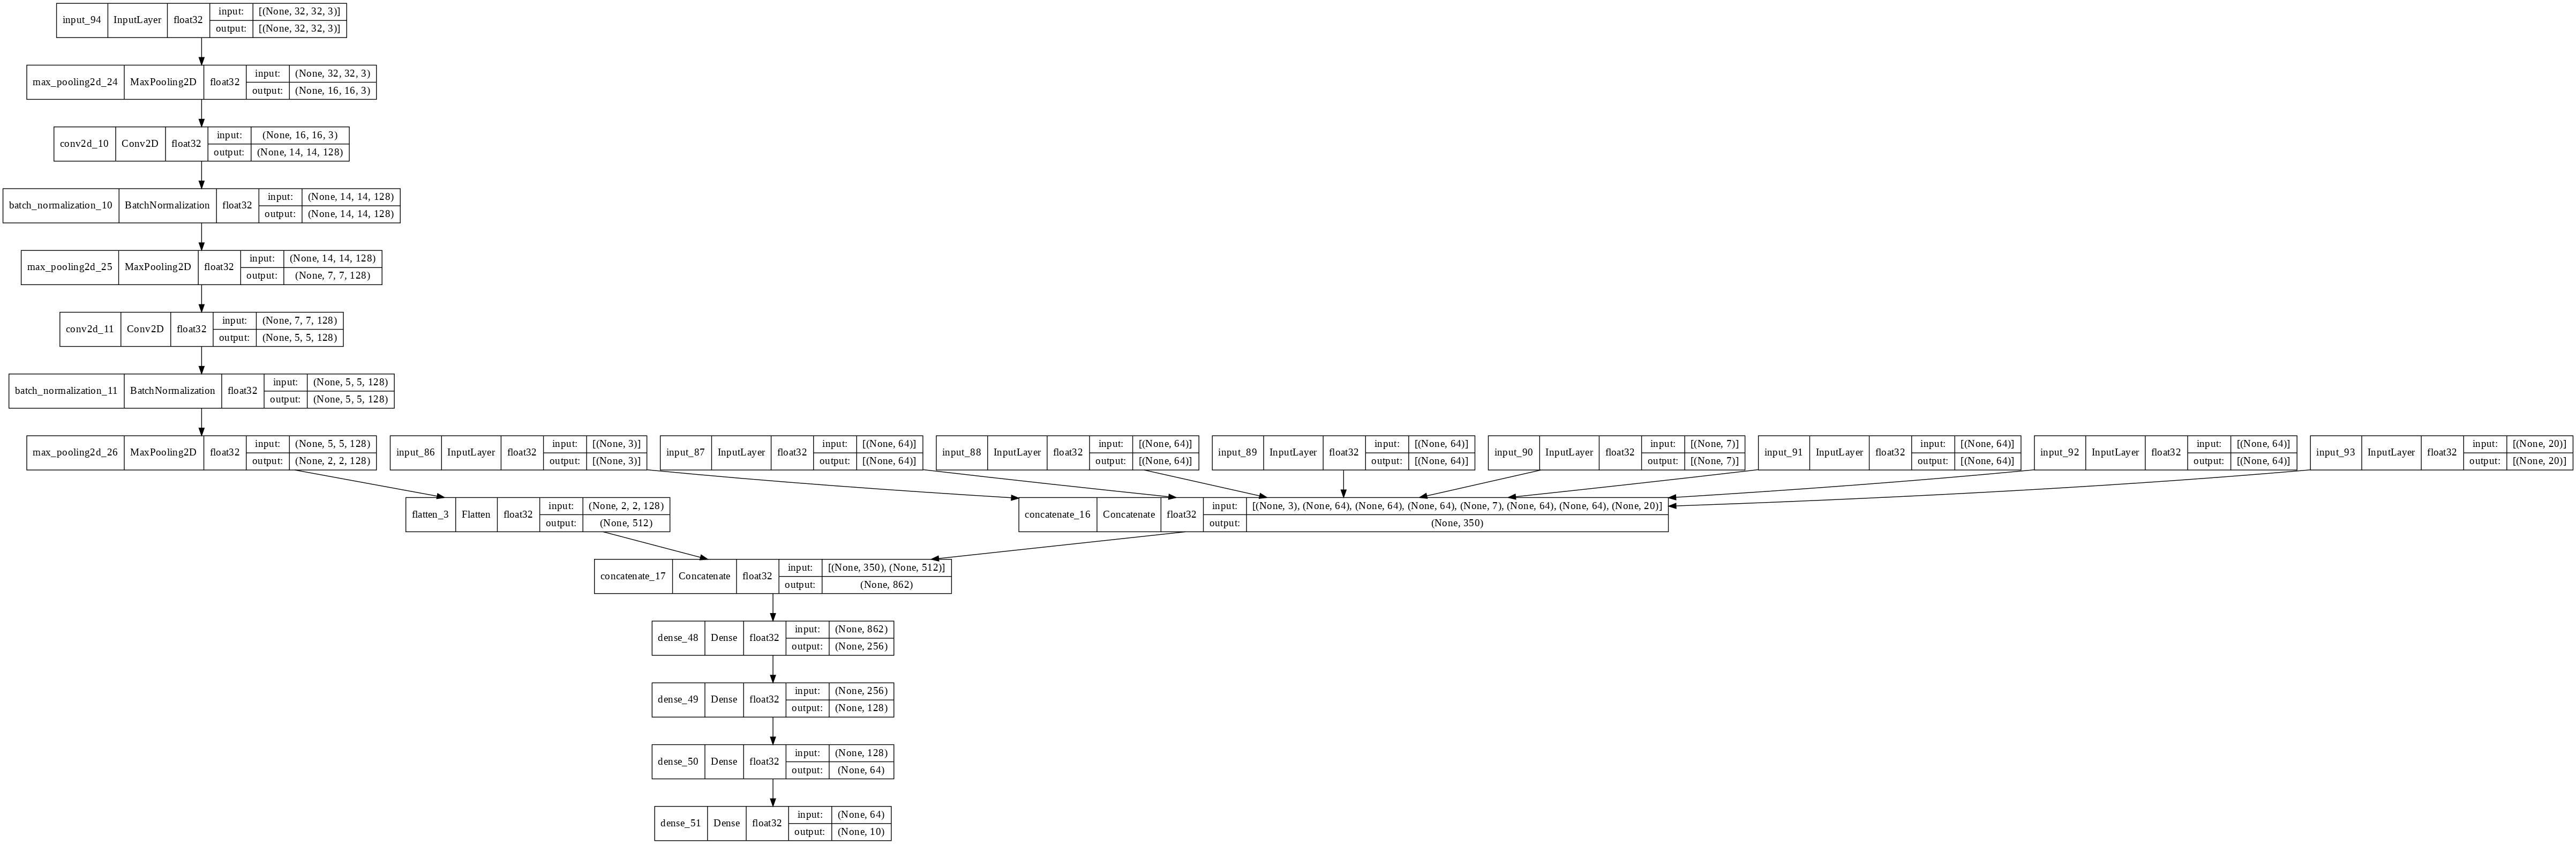

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=100
)

###256 Deep Input + 350 Wide Input
- Max Accuracy is 0.9428

In [ ]:
layers = tf.keras.layers

wide256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=256, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection

merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide256_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_112 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_112[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_30[0][0]']       
                                                                                                  
 batch_normalization_16 (BatchN  (None, 14, 14, 128)  512        ['conv2d_16[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_256 = wide256_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             batch_size = batch_size,
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 15s 44ms/step - loss: 0.9994 - accuracy: 0.6373 - val_loss: 4.1832 - val_accuracy: 0.2007
Epoch 2/20
338/338 [==============================] - 16s 46ms/step - loss: 0.7692 - accuracy: 0.7229 - val_loss: 7.1043 - val_accuracy: 0.2372
Epoch 3/20
338/338 [==============================] - 14s 43ms/step - loss: 0.6761 - accuracy: 0.7543 - val_loss: 0.7972 - val_accuracy: 0.7117
Epoch 4/20
338/338 [==============================] - 14s 42ms/step - loss: 0.6133 - accuracy: 0.7779 - val_loss: 0.8055 - val_accuracy: 0.7113
Epoch 5/20
338/338 [==============================] - 14s 42ms/step - loss: 0.5693 - accuracy: 0.7980 - val_loss: 0.8636 - val_accuracy: 0.6894
Epoch 6/20
338/338 [==============================] - 15s 46ms/step - loss: 0.5055 - accuracy: 0.8196 - val_loss: 1.2955 - val_accuracy: 0.6067
Epoch 7/20
338/338 [==============================] - 14s 43ms/step - loss: 0.4635 - accuracy: 0.8348 - val_loss: 2.8506 - val_accuracy:

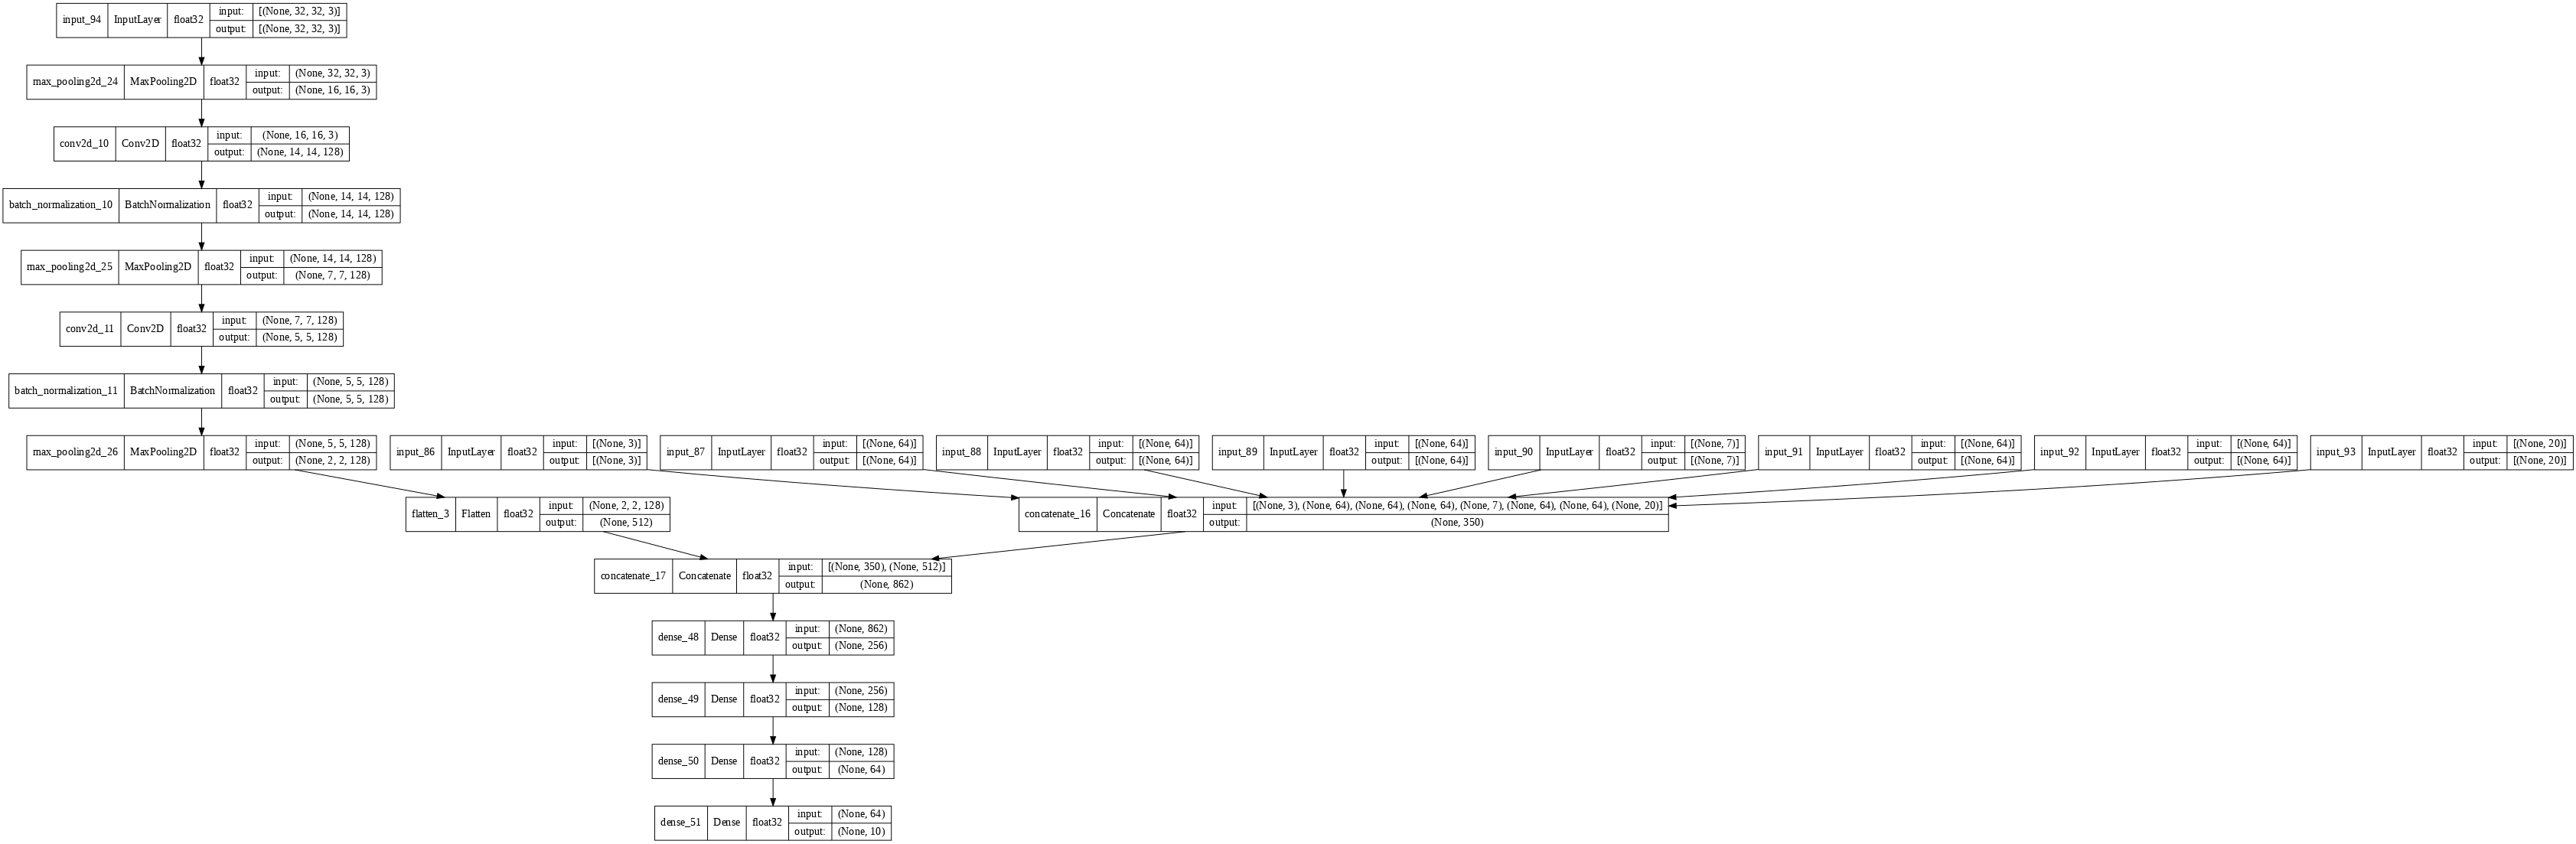

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

###256 Deep Input + 350 Wide Input METHOD 2
- Max Accuracy is 0.9116

In [ ]:
layers = tf.keras.layers

wide256_2_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide256_2_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide256_2_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide256_2_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_139 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_139[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_39[0][0]']       
                                                                                                  
 batch_normalization_25 (BatchN  (None, 14, 14, 128)  512        ['conv2d_25[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_256_2 = wide256_2_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             batch_size = batch_size,
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 16s 46ms/step - loss: 1.0119 - accuracy: 0.6318 - val_loss: 3.5035 - val_accuracy: 0.2070
Epoch 2/20
338/338 [==============================] - 15s 45ms/step - loss: 0.7616 - accuracy: 0.7269 - val_loss: 2.4625 - val_accuracy: 0.4165
Epoch 3/20
338/338 [==============================] - 14s 42ms/step - loss: 0.6789 - accuracy: 0.7524 - val_loss: 1.1649 - val_accuracy: 0.5996
Epoch 4/20
338/338 [==============================] - 15s 45ms/step - loss: 0.6101 - accuracy: 0.7803 - val_loss: 0.9073 - val_accuracy: 0.6748
Epoch 5/20
338/338 [==============================] - 14s 42ms/step - loss: 0.5670 - accuracy: 0.7989 - val_loss: 0.8844 - val_accuracy: 0.7063
Epoch 6/20
338/338 [==============================] - 15s 45ms/step - loss: 0.5387 - accuracy: 0.8077 - val_loss: 0.7112 - val_accuracy: 0.7435
Epoch 7/20
338/338 [==============================] - 14s 42ms/step - loss: 0.5048 - accuracy: 0.8190 - val_loss: 0.7992 - val_accuracy:

###128 Deep Input + 350 Wide Input
- Max Accuracy is 0.9419

In [ ]:
layers = tf.keras.layers

wide128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=256, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide128_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide128_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_121 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_121[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_33[0][0]']       
                                                                                                  
 batch_normalization_19 (BatchN  (None, 14, 14, 128)  512        ['conv2d_19[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_128 = wide128_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             batch_size = batch_size,
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 16s 46ms/step - loss: 0.9865 - accuracy: 0.6413 - val_loss: 3.5658 - val_accuracy: 0.2480
Epoch 2/20
338/338 [==============================] - 14s 43ms/step - loss: 0.7561 - accuracy: 0.7279 - val_loss: 2.3965 - val_accuracy: 0.4359
Epoch 3/20
338/338 [==============================] - 15s 43ms/step - loss: 0.6522 - accuracy: 0.7671 - val_loss: 4.2575 - val_accuracy: 0.3035
Epoch 4/20
338/338 [==============================] - 15s 45ms/step - loss: 0.5704 - accuracy: 0.7985 - val_loss: 2.5354 - val_accuracy: 0.4594
Epoch 5/20
338/338 [==============================] - 14s 43ms/step - loss: 0.5180 - accuracy: 0.8170 - val_loss: 1.8136 - val_accuracy: 0.4419
Epoch 6/20
338/338 [==============================] - 15s 45ms/step - loss: 0.4868 - accuracy: 0.8295 - val_loss: 0.8056 - val_accuracy: 0.7265
Epoch 7/20
338/338 [==============================] - 15s 45ms/step - loss: 0.4279 - accuracy: 0.8470 - val_loss: 2.6092 - val_accuracy:

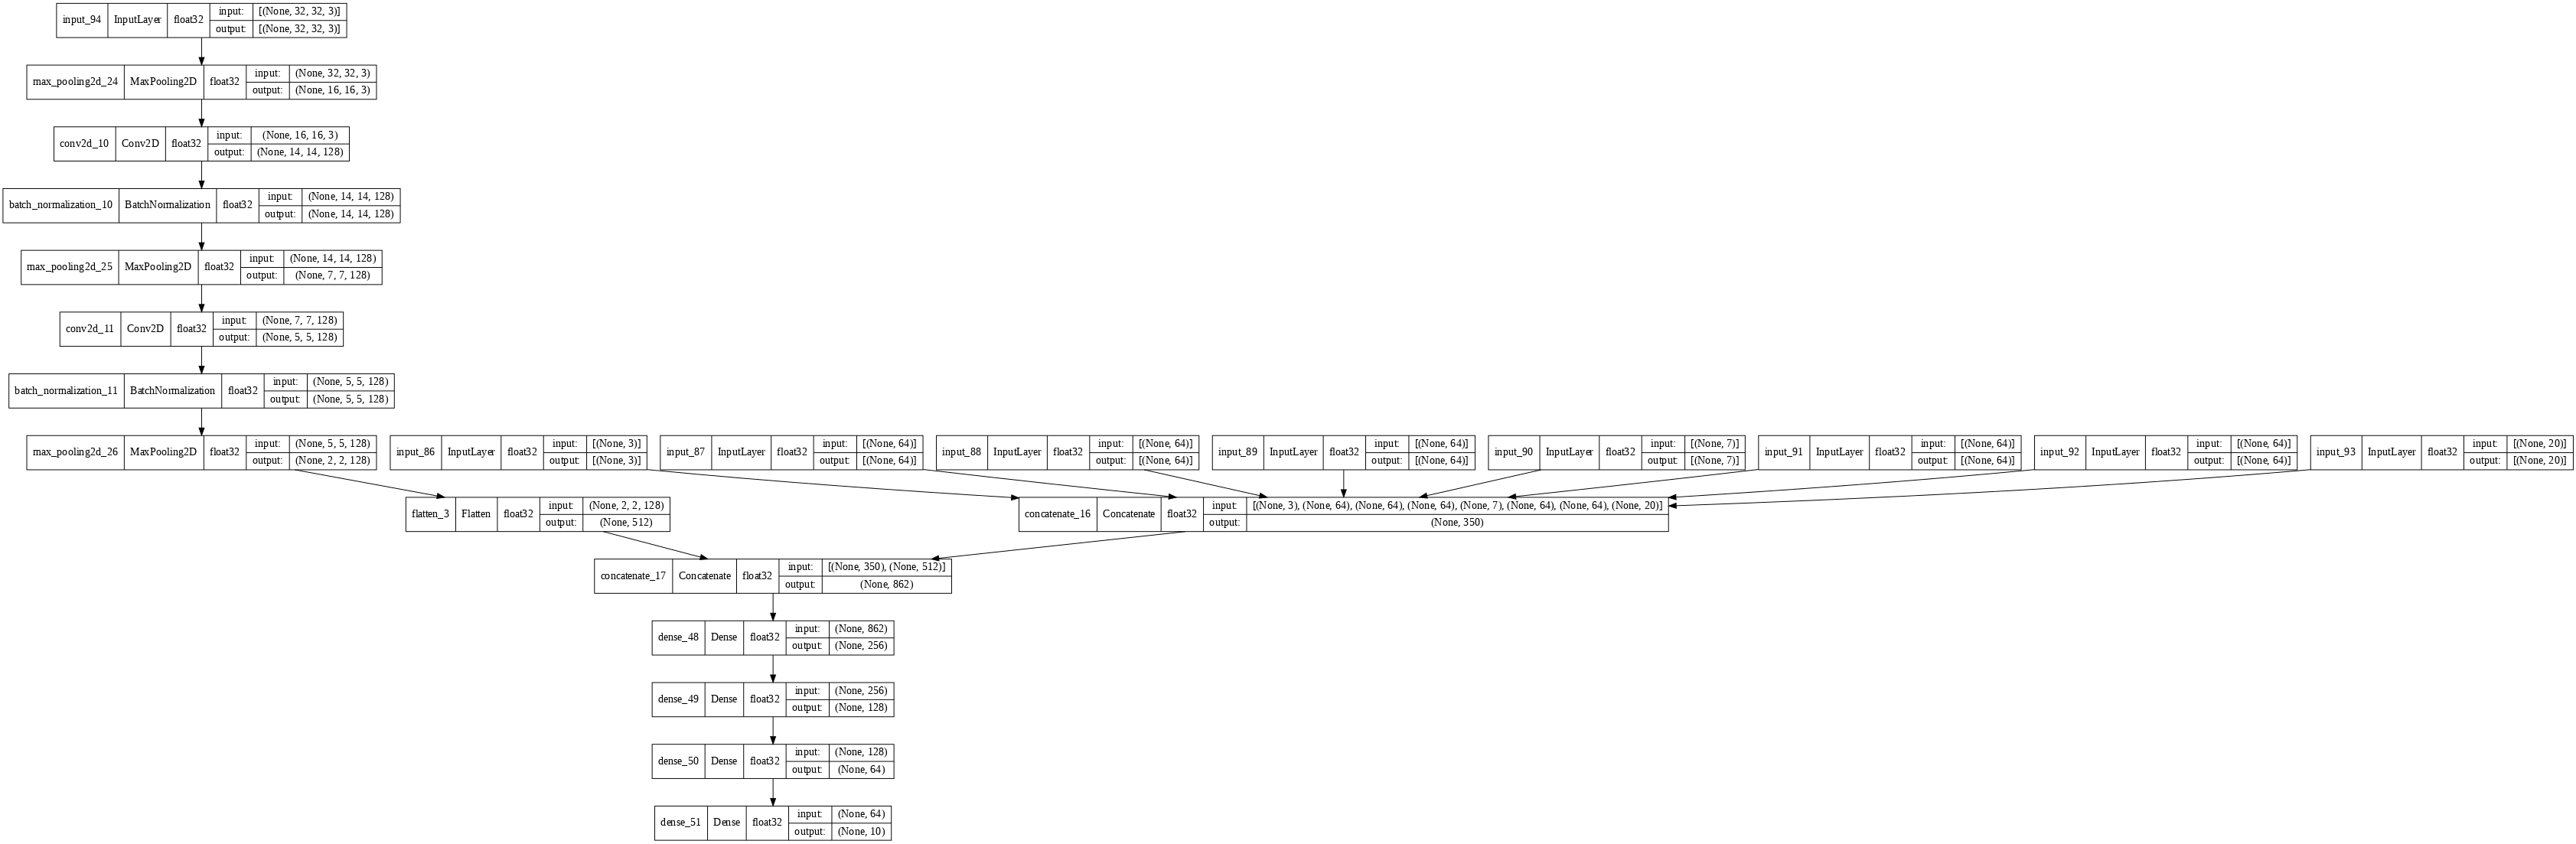

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

### RESULTS Comparisons

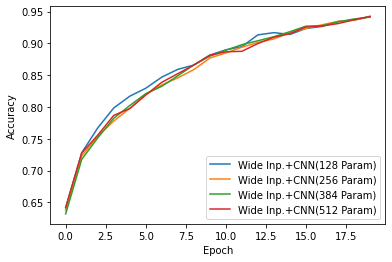

In [ ]:
#plt.plot(history_cnn.history['accuracy'])
plt.plot(history_128.history['accuracy'])
plt.plot(history_256.history['accuracy'])
plt.plot(history_384.history['accuracy'])
plt.plot(history_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Wide Inp.+CNN(128 Param)', 'Wide Inp.+CNN(256 Param)' , 'Wide Inp.+CNN(384 Param)', 'Wide Inp.+CNN(512 Param)'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# **2nd Model Experiments**

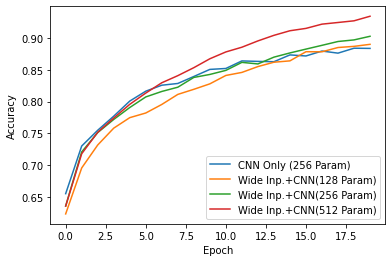

## Sequential Custom CNN Solution 256 Params.
- With Keras Preprocessing Data Augmentation
- 1 Dense Layer
- Max Accuracy 0.8839


In [105]:
model256 = tf.keras.Sequential([
                              
    layers.Input(shape=input_shape),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.25),
    #Conv Layer 1
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 2
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 3
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=CLASS_NUMBER, activation='softmax')
])

model256.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model256.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 random_contrast_1 (RandomCo  (None, 32, 32, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_14 (Bat  (None, 30, 30, 64)       256       
 chNormalization)                                                
                                                      

In [104]:
history_CNN256 = model256.fit(x_train, 
                             y_train,
                             epochs = epochs,
                             validation_data=(x_test, y_test)
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20


KeyboardInterrupt: ignored

## Sequential Custom CNN Solution + Wide Inputs




### 256 Deep Input + 350 Wide Input
- With Keras Preprocessing Data Augmentation
- 1 Dense Layer
- Max Accuracy 0.9026

In [ ]:
layers = tf.keras.layers

wide256_model_e2 = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

x = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
x = layers.experimental.preprocessing.RandomContrast(0.25)(x)
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide256_model_e2 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide256_model_e2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_256 = wide256_model_e2.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 28s 41ms/step - loss: 1.0061 - accuracy: 0.6361 - val_loss: 1.1171 - val_accuracy: 0.6011
Epoch 2/20
675/675 [==============================] - 27s 41ms/step - loss: 0.7794 - accuracy: 0.7210 - val_loss: 3.4591 - val_accuracy: 0.3374
Epoch 3/20
675/675 [==============================] - 27s 41ms/step - loss: 0.6860 - accuracy: 0.7514 - val_loss: 1.5693 - val_accuracy: 0.5372
Epoch 4/20
675/675 [==============================] - 25s 37ms/step - loss: 0.6340 - accuracy: 0.7720 - val_loss: 1.4183 - val_accuracy: 0.5202
Epoch 5/20
675/675 [==============================] - 27s 40ms/step - loss: 0.5846 - accuracy: 0.7907 - val_loss: 1.2172 - val_accuracy: 0.5981
Epoch 6/20
675/675 [==============================] - 25s 37ms/step - loss: 0.5420 - accuracy: 0.8074 - val_loss: 1.8995 - val_accuracy: 0.5267
Epoch 7/20
675/675 [==============================] - 27s 40ms/step - loss: 0.5108 - accuracy: 0.8160 - val_loss: 1.4437 - val_accuracy:

### 512 Deep Input + 350 Wide Input
- With Keras Preprocessing Data Augmentation
- 1 Dense Layer
- Max Accuracy 0.9341

In [ ]:
layers = tf.keras.layers

wide512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
x = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
x = layers.experimental.preprocessing.RandomContrast(0.25)(x)
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection

merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide512_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_176 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_54 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_176[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 14, 14, 64)   1792        ['max_pooling2d_54[0][0]']       
                                                                                                  
 batch_normalization_40 (BatchN  (None, 14, 14, 64)  256         ['conv2d_40[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_512 = wide512_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 29s 43ms/step - loss: 1.0142 - accuracy: 0.6359 - val_loss: 2.1331 - val_accuracy: 0.4743
Epoch 2/20
675/675 [==============================] - 26s 39ms/step - loss: 0.7822 - accuracy: 0.7181 - val_loss: 2.1549 - val_accuracy: 0.3898
Epoch 3/20
675/675 [==============================] - 29s 42ms/step - loss: 0.6948 - accuracy: 0.7519 - val_loss: 1.2330 - val_accuracy: 0.5746
Epoch 4/20
675/675 [==============================] - 27s 39ms/step - loss: 0.6182 - accuracy: 0.7742 - val_loss: 0.8662 - val_accuracy: 0.7015
Epoch 5/20
675/675 [==============================] - 26s 39ms/step - loss: 0.5663 - accuracy: 0.7957 - val_loss: 1.2897 - val_accuracy: 0.6170
Epoch 6/20
675/675 [==============================] - 27s 39ms/step - loss: 0.5193 - accuracy: 0.8134 - val_loss: 1.0242 - val_accuracy: 0.6687
Epoch 7/20
675/675 [==============================] - 29s 43ms/step - loss: 0.4754 - accuracy: 0.8296 - val_loss: 1.1819 - val_accuracy:

###128 Deep Input + 350 Wide Input
- With Keras Preprocessing Data Augmentation
- 1 Dense Layer
- Max Accuracy 0.8900

In [ ]:
layers = tf.keras.layers

wide128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
x = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
x = layers.experimental.preprocessing.RandomContrast(0.25)(x)
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide128_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide128_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_185 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_57 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_185[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 14, 14, 64)   1792        ['max_pooling2d_57[0][0]']       
                                                                                                  
 batch_normalization_43 (BatchN  (None, 14, 14, 64)  256         ['conv2d_43[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_128 = wide128_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

Epoch 1/20
  1/675 [..............................] - ETA: 45s - loss: 2.4492 - accuracy: 0.0625

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


675/675 [==============================] - 27s 40ms/step - loss: 1.0318 - accuracy: 0.6236 - val_loss: 1.0778 - val_accuracy: 0.5900
Epoch 2/20
675/675 [==============================] - 26s 39ms/step - loss: 0.8374 - accuracy: 0.6958 - val_loss: 1.1249 - val_accuracy: 0.6148
Epoch 3/20
675/675 [==============================] - 27s 39ms/step - loss: 0.7381 - accuracy: 0.7319 - val_loss: 0.9569 - val_accuracy: 0.6591
Epoch 4/20
675/675 [==============================] - 27s 40ms/step - loss: 0.6736 - accuracy: 0.7583 - val_loss: 1.3705 - val_accuracy: 0.5815
Epoch 5/20
675/675 [==============================] - 27s 39ms/step - loss: 0.6228 - accuracy: 0.7748 - val_loss: 1.0274 - val_accuracy: 0.6467
Epoch 6/20
675/675 [==============================] - 27s 39ms/step - loss: 0.6078 - accuracy: 0.7821 - val_loss: 0.6954 - val_accuracy: 0.7476
Epoch 7/20
675/675 [==============================] - 29s 42ms/step - loss: 0.5587 - accuracy: 0.7956 - val_loss: 2.6528 - val_accuracy: 0.4065
Epo

## RESULTS Comparisons

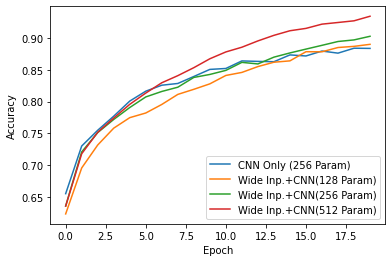

In [ ]:
plt.plot(history_CNN256.history['accuracy'])
plt.plot(history_128.history['accuracy'])
plt.plot(history_256.history['accuracy'])
plt.plot(history_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only (256 Param)','Wide Inp.+CNN(128 Param)', 'Wide Inp.+CNN(256 Param)' , 'Wide Inp.+CNN(512 Param)'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

In [ ]:

from matplotlib.pyplot import figure
plt.figure(figsize=(18, 10), dpi=65)
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN')

plt.plot(CORRhistory.history['accuracy'],label='>GLCM(Correlation) Only< Wide-CNN')
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN') 
plt.plot(history_mean_only.history['accuracy'],label='>Mean Value Only< Wide-CNN')
plt.plot(history_cnn.history['accuracy'],label='Deep Learning-CNN Only')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()



In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)
print(classification_report(y_test, y_pred))

# **3rd Model Experiments** not done yet.



## Sequential Custom CNN Solution Only 2304 Parameters




In [ ]:
model = tf.keras.Sequential([                        
    layers.Input(shape=input_shape),
    #Conv Layer 1
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    #Conv Layer 2
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=CLASS_NUMBER, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_9 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 13, 13, 64)      

In [ ]:
history_cnn_exp2 = model.fit( x_train,
                         y_train,
                         validation_data=(x_test,y_test),
                         epochs=epochs, 
                         #callbacks = [reduce_lr]
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 23s 26ms/step - loss: 0.2424 - accuracy: 0.9087 - val_loss: 0.3981 - val_accuracy: 0.8479
Epoch 2/16
900/900 [==============================] - 23s 26ms/step - loss: 0.1364 - accuracy: 0.9502 - val_loss: 0.1327 - val_accuracy: 0.9542
Epoch 3/16
900/900 [==============================] - 23s 25ms/step - loss: 0.1036 - accuracy: 0.9620 - val_loss: 0.3053 - val_accuracy: 0.8608
Epoch 4/16
900/900 [==============================] - 23s 25ms/step - loss: 0.0924 - accuracy: 0.9672 - val_loss: 0.2315 - val_accuracy: 0.9050
Epoch 5/16
900/900 [==============================] - 23s 26ms/step - loss: 0.0888 - accuracy: 0.9671 - val_loss: 0.2267 - val_accuracy: 0.9215
Epoch 6/16
900/900 [==============================] - 23s 26ms/step - loss: 0.0739 - accuracy: 0.9735 - val_loss: 0.1116 - val_accuracy: 0.9614
Epoch 7/16
900/900 [==============================] - 23s 26ms/step - loss: 0.0679 - accuracy: 0.9762 - val_loss: 0.1720 - val_accuracy:

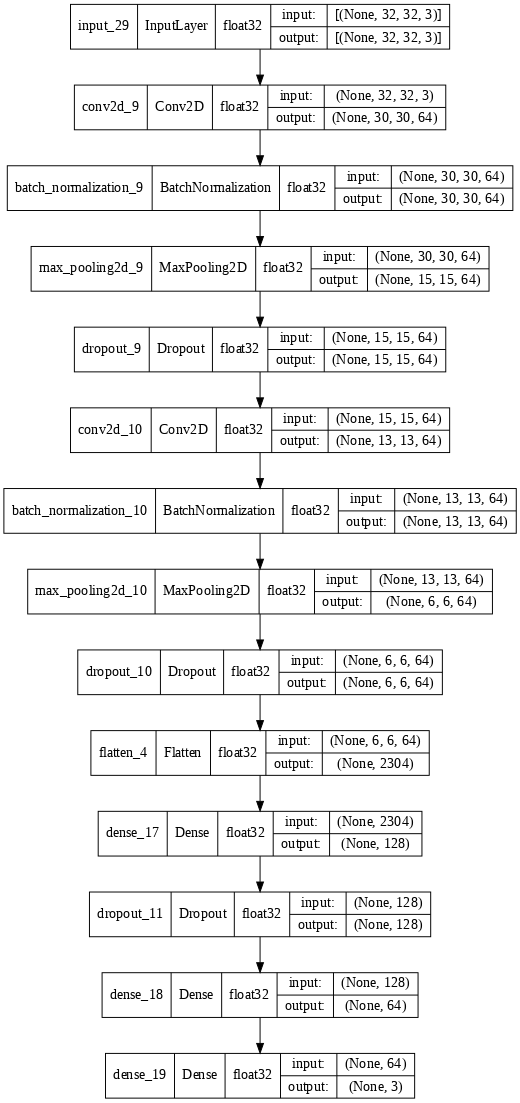

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

## Sequential Custom CNN Solution 2304 Params + Wide Inputs 350 Params






In [ ]:
layers = tf.keras.layers

wide_model4 = tf.keras.Sequential()                              

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide_model4 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 30, 30, 64)   1792        ['input_38[0][0]']               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 30, 30, 64)  256         ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 15, 15, 64)  0           ['batch_normalization_11[0]

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = wide_model4.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 25s 28ms/step - loss: 0.2429 - accuracy: 0.9067 - val_loss: 0.1098 - val_accuracy: 0.9590
Epoch 2/16
900/900 [==============================] - 25s 28ms/step - loss: 0.1443 - accuracy: 0.9473 - val_loss: 0.2484 - val_accuracy: 0.9061
Epoch 3/16
900/900 [==============================] - 27s 30ms/step - loss: 0.1094 - accuracy: 0.9596 - val_loss: 0.1070 - val_accuracy: 0.9610
Epoch 4/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0889 - accuracy: 0.9676 - val_loss: 0.3158 - val_accuracy: 0.8976
Epoch 5/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0869 - accuracy: 0.9671 - val_loss: 0.1059 - val_accuracy: 0.9604
Epoch 6/16
900/900 [==============================] - 25s 28ms/step - loss: 0.0760 - accuracy: 0.9735 - val_loss: 0.2635 - val_accuracy: 0.9189
Epoch 7/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0656 - accuracy: 0.9774 - val_loss: 0.0721 - val_accuracy:

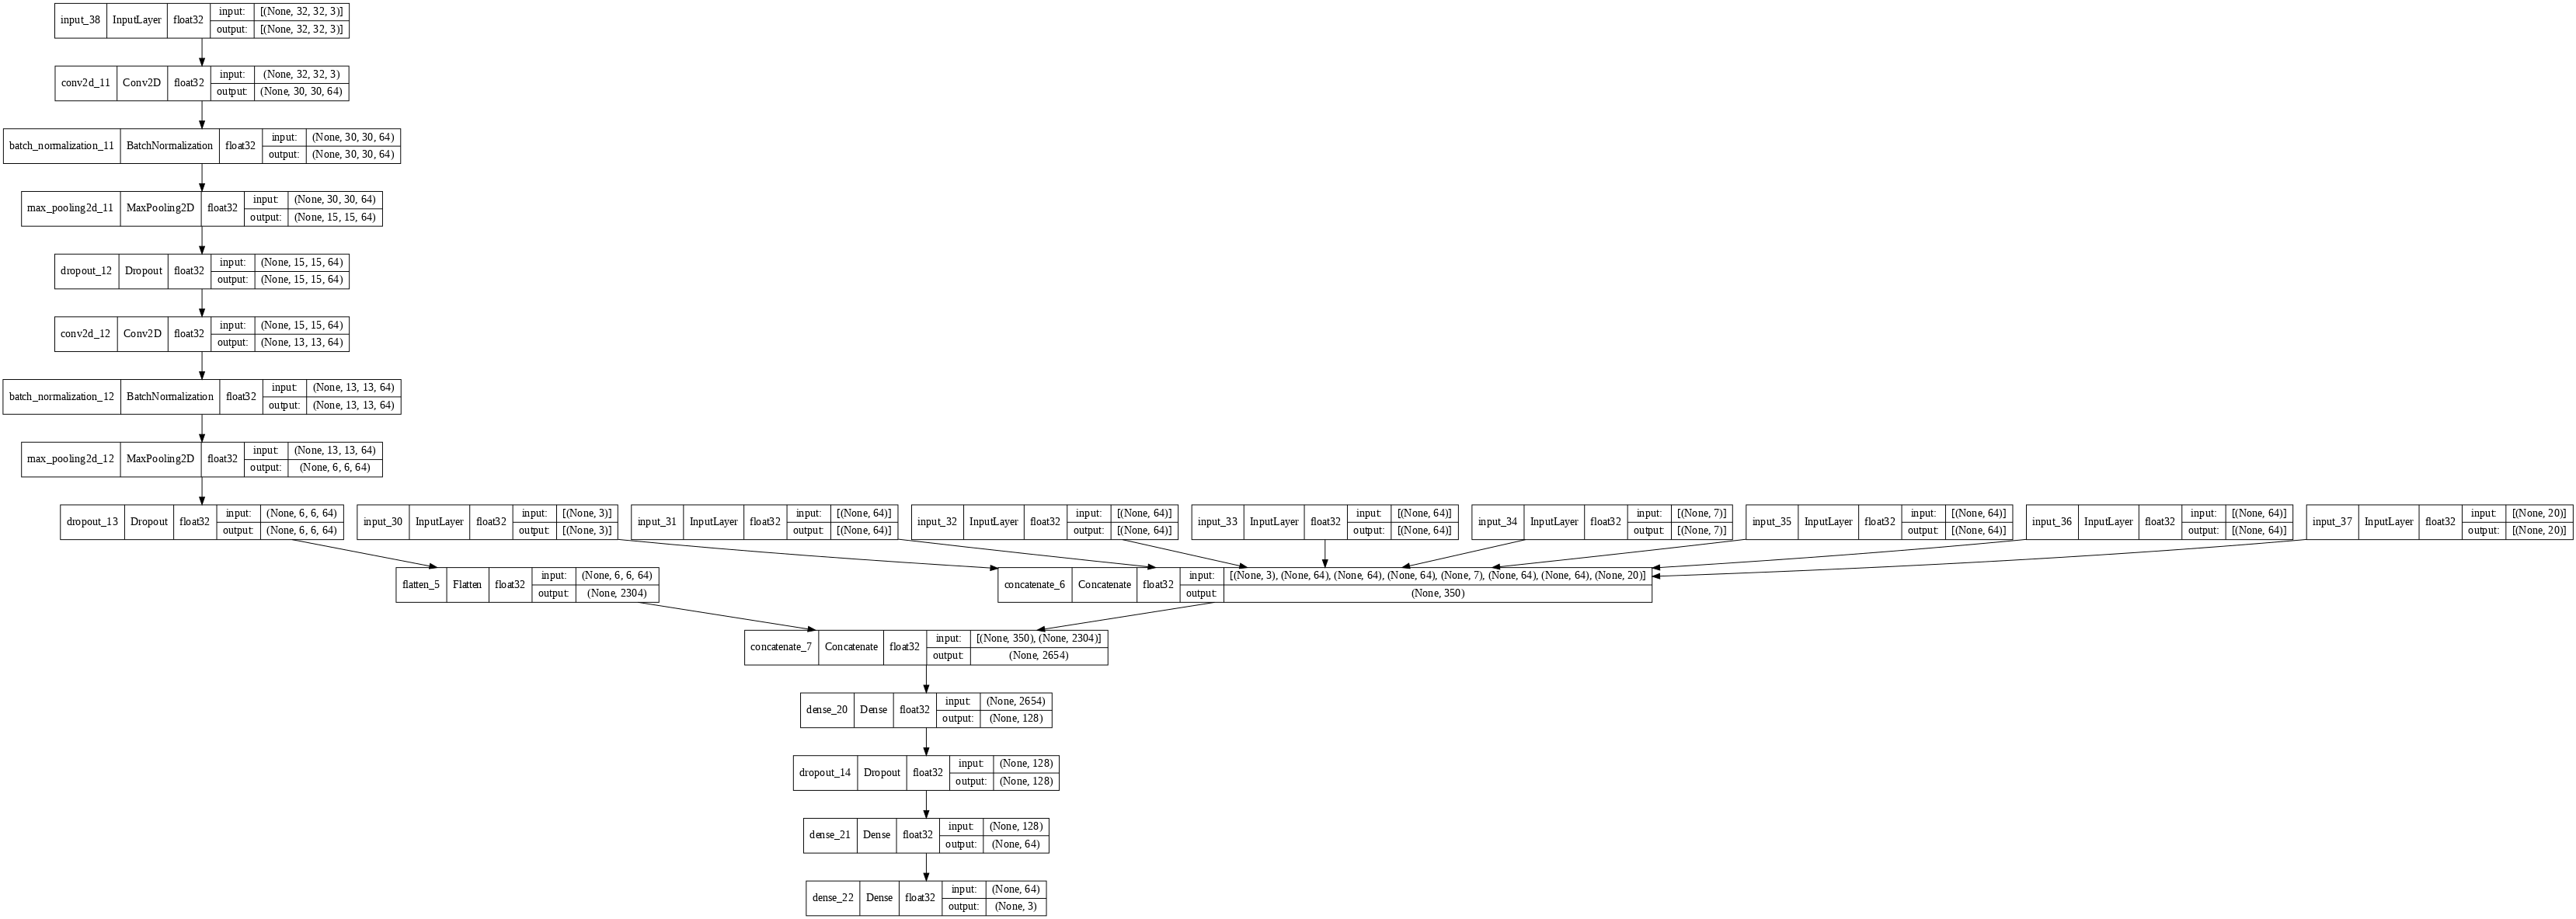

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_model4, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

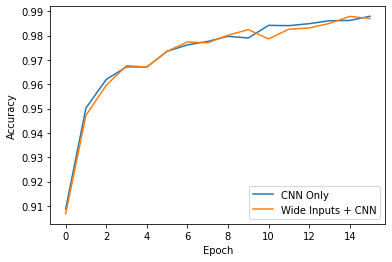

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs + CNN'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## Sequential Custom CNN Solution 1152 Params + Wide Inputs 350 Params






In [ ]:
layers = tf.keras.layers

wide_model1152 = tf.keras.Sequential()                              

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=1152, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide_model1152 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model1152.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model1152.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 30, 30, 64)   1792        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 30, 30, 64)  256         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 15, 15, 64)  0           ['batch_normalization_3[0][0]

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_wide_model1152 = wide_model1152.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 29s 33ms/step - loss: 0.2509 - accuracy: 0.9066 - val_loss: 1.3260 - val_accuracy: 0.7628
Epoch 2/16
900/900 [==============================] - 27s 30ms/step - loss: 0.1236 - accuracy: 0.9557 - val_loss: 0.3057 - val_accuracy: 0.8700
Epoch 3/16
900/900 [==============================] - 29s 32ms/step - loss: 0.0915 - accuracy: 0.9674 - val_loss: 1.4900 - val_accuracy: 0.8138
Epoch 4/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0740 - accuracy: 0.9740 - val_loss: 0.1092 - val_accuracy: 0.9636
Epoch 5/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0601 - accuracy: 0.9800 - val_loss: 0.0641 - val_accuracy: 0.9782
Epoch 6/16
900/900 [==============================] - 27s 30ms/step - loss: 0.0535 - accuracy: 0.9813 - val_loss: 0.0685 - val_accuracy: 0.9767
Epoch 7/16
900/900 [==============================] - 29s 32ms/step - loss: 0.0437 - accuracy: 0.9845 - val_loss: 7.7145 - val_accuracy:

**RESULTS**

## Sequential Custom CNN Solution 576 Params + Wide Inputs 350 Params






In [ ]:
layers = tf.keras.layers

wide_model576 = tf.keras.Sequential()                              

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=1152, activation='relu')(x)
x = layers.Dense(units=576, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide_model576 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model576.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model576.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 30, 30, 64)   1792        ['input_19[0][0]']               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 30, 30, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 15, 15, 64)  0           ['batch_normalization_5[0][

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_wide_model576 = wide_model576.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 30s 34ms/step - loss: 0.2186 - accuracy: 0.9199 - val_loss: 1.0017 - val_accuracy: 0.7719
Epoch 2/16
900/900 [==============================] - 30s 34ms/step - loss: 0.1215 - accuracy: 0.9568 - val_loss: 0.2982 - val_accuracy: 0.8583
Epoch 3/16
900/900 [==============================] - 30s 34ms/step - loss: 0.0949 - accuracy: 0.9666 - val_loss: 0.1649 - val_accuracy: 0.9203
Epoch 4/16
900/900 [==============================] - 28s 31ms/step - loss: 0.0696 - accuracy: 0.9762 - val_loss: 0.4522 - val_accuracy: 0.8835
Epoch 5/16
900/900 [==============================] - 30s 34ms/step - loss: 0.0627 - accuracy: 0.9791 - val_loss: 0.1234 - val_accuracy: 0.9496
Epoch 6/16
900/900 [==============================] - 30s 33ms/step - loss: 0.0546 - accuracy: 0.9810 - val_loss: 0.0563 - val_accuracy: 0.9801
Epoch 7/16
900/900 [==============================] - 28s 31ms/step - loss: 0.0460 - accuracy: 0.9843 - val_loss: 0.0878 - val_accuracy:

**RESULTS**

## Sequential Custom CNN Solution 128 Params + Wide Inputs 350 Params






In [ ]:
layers = tf.keras.layers

wide_model128 = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide_model128 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model128.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model128.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 30, 30, 64)   1792        ['input_28[0][0]']               
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 30, 30, 64)  256         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 15, 15, 64)  0           ['batch_normalization_7[0][

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_wide_model128 = wide_model128.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 29s 31ms/step - loss: 0.1969 - accuracy: 0.9257 - val_loss: 1.2778 - val_accuracy: 0.7669
Epoch 2/16
900/900 [==============================] - 26s 29ms/step - loss: 0.1099 - accuracy: 0.9597 - val_loss: 1.1634 - val_accuracy: 0.7832
Epoch 3/16
900/900 [==============================] - 28s 32ms/step - loss: 0.0863 - accuracy: 0.9692 - val_loss: 0.4771 - val_accuracy: 0.8662
Epoch 4/16
900/900 [==============================] - 26s 29ms/step - loss: 0.0732 - accuracy: 0.9750 - val_loss: 0.1554 - val_accuracy: 0.9374
Epoch 5/16
900/900 [==============================] - 26s 29ms/step - loss: 0.0692 - accuracy: 0.9754 - val_loss: 0.2885 - val_accuracy: 0.9329
Epoch 6/16
900/900 [==============================] - 28s 32ms/step - loss: 0.0536 - accuracy: 0.9808 - val_loss: 0.1705 - val_accuracy: 0.9215
Epoch 7/16
900/900 [==============================] - 28s 31ms/step - loss: 0.0500 - accuracy: 0.9833 - val_loss: 0.0519 - val_accuracy:

**RESULTS**

## Sequential Custom CNN Solution 2304 Params + GLCM





In [ ]:
layers = tf.keras.layers

wide_modelInvariant = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
#x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([#wideInput0,
                                              #wideInputInvariantRed,
                                              #wideInputInvariantGreen,
                                              #wideInputInvariantBlue, 
                                              #wideInputHU,
                                              #wideInputHOG,
                                              #wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

wide_modelInvariant = tf.keras.Model(inputs=[#wideInput0, 
                                     #wideInputInvariantRed,
                                     #wideInputInvariantGreen,
                                     #wideInputInvariantBlue, 
                                     #wideInputHU,
                                     #wideInputHOG,
                                     #wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_modelInvariant.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_modelInvariant.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_124 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 30, 30, 64)   1792        ['input_124[0][0]']              
                                                                                                  
 batch_normalization_36 (BatchN  (None, 30, 30, 64)  256         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_43 (MaxPooling2D  (None, 15, 15, 64)  0           ['batch_normalization_36[0

In [ ]:
GLCMdata_trainMerged = [#x_train_mean ,
                        #x_train_invariant_Red,
                        #x_train_invariant_Green,
                        #x_train_invariant_Blue,
                        #x_train_HU,
                        #x_train_hog_vector,
                        #x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [#x_test_mean,
                      #x_test_invariant_Red, 
                      #x_test_invariant_Green,
                      #x_test_invariant_Blue,
                      #x_test_HU,
                      #x_test_hog_vector,
                      #x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_wide_modelInvariant = wide_modelInvariant.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 36s 40ms/step - loss: 0.2455 - accuracy: 0.9079 - val_loss: 0.1915 - val_accuracy: 0.9275
Epoch 2/16
900/900 [==============================] - 37s 41ms/step - loss: 0.1274 - accuracy: 0.9522 - val_loss: 0.1257 - val_accuracy: 0.9529
Epoch 3/16
900/900 [==============================] - 37s 41ms/step - loss: 0.1063 - accuracy: 0.9624 - val_loss: 0.5953 - val_accuracy: 0.8268
Epoch 4/16
900/900 [==============================] - 37s 41ms/step - loss: 0.0903 - accuracy: 0.9680 - val_loss: 0.9164 - val_accuracy: 0.8046
Epoch 5/16
900/900 [==============================] - 36s 40ms/step - loss: 0.0790 - accuracy: 0.9719 - val_loss: 0.0902 - val_accuracy: 0.9660
Epoch 6/16
900/900 [==============================] - 36s 40ms/step - loss: 0.0698 - accuracy: 0.9744 - val_loss: 0.1699 - val_accuracy: 0.9364
Epoch 7/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0660 - accuracy: 0.9761 - val_loss: 0.1036 - val_accuracy:

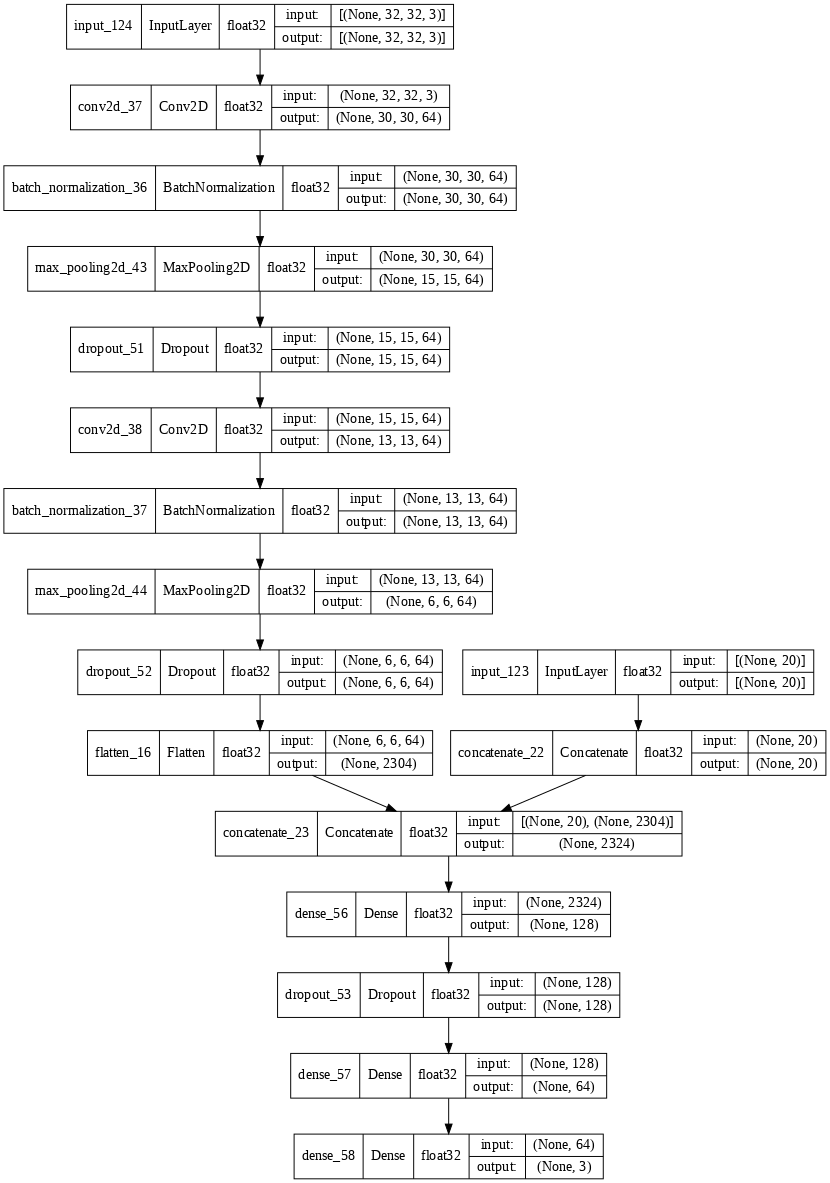

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_modelInvariant, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

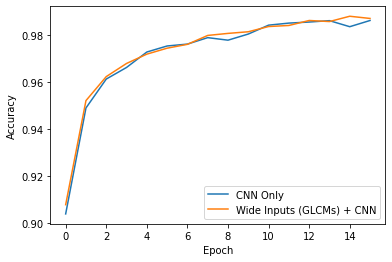

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_wide_modelInvariant.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs (GLCMs) + CNN'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=400)  
plt.savefig('aLLhistory.pdf')

# **Pre-trained Model Experiments - Transfer Learning**

---

These models are called from Keras tensorflow applications: [https://www.tensorflow.org/api_docs/python/tf/keras/applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

# **VGG16**

In [85]:
from tensorflow.keras.applications import VGG16

## VGG16 Deep Learning Only
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8925

In [86]:
base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 10)                1290

In [ ]:
history_VGG16 = VGG16_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 50s 114ms/step - loss: 0.8868 - accuracy: 0.6882 - val_loss: 0.7043 - val_accuracy: 0.7446
Epoch 2/20
338/338 [==============================] - 37s 111ms/step - loss: 0.6309 - accuracy: 0.7776 - val_loss: 0.5982 - val_accuracy: 0.7869
Epoch 3/20
338/338 [==============================] - 37s 110ms/step - loss: 0.5730 - accuracy: 0.7930 - val_loss: 0.5676 - val_accuracy: 0.7998
Epoch 4/20
338/338 [==============================] - 37s 111ms/step - loss: 0.5318 - accuracy: 0.8101 - val_loss: 0.5581 - val_accuracy: 0.7987
Epoch 5/20
338/338 [==============================] - 38s 112ms/step - loss: 0.5082 - accuracy: 0.8175 - val_loss: 0.5115 - val_accuracy: 0.8252
Epoch 6/20
338/338 [==============================] - 38s 112ms/step - loss: 0.4834 - accuracy: 0.8274 - val_loss: 0.5332 - val_accuracy: 0.8176
Epoch 7/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4592 - accuracy: 0.8355 - val_loss: 0.5072 - val_ac

## VGG16 512Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8705

In [ ]:
VGG16WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 40s 118ms/step - loss: 0.9308 - accuracy: 0.6713 - val_loss: 0.6942 - val_accuracy: 0.7493
Epoch 2/20
338/338 [==============================] - 38s 112ms/step - loss: 0.6640 - accuracy: 0.7627 - val_loss: 0.6268 - val_accuracy: 0.7748
Epoch 3/20
338/338 [==============================] - 40s 117ms/step - loss: 0.6066 - accuracy: 0.7829 - val_loss: 0.6456 - val_accuracy: 0.7641
Epoch 4/20
338/338 [==============================] - 38s 111ms/step - loss: 0.5649 - accuracy: 0.7986 - val_loss: 0.5438 - val_accuracy: 0.8096
Epoch 5/20
338/338 [==============================] - 40s 117ms/step - loss: 0.5452 - accuracy: 0.8060 - val_loss: 0.5509 - val_accuracy: 0.8054
Epoch 6/20
338/338 [==============================] - 38s 111ms/step - loss: 0.5230 - accuracy: 0.8125 - val_loss: 0.5379 - val_accuracy: 0.8109
Epoch 7/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5057 - accuracy: 0.8191 - val_loss: 0.5426 - val_ac

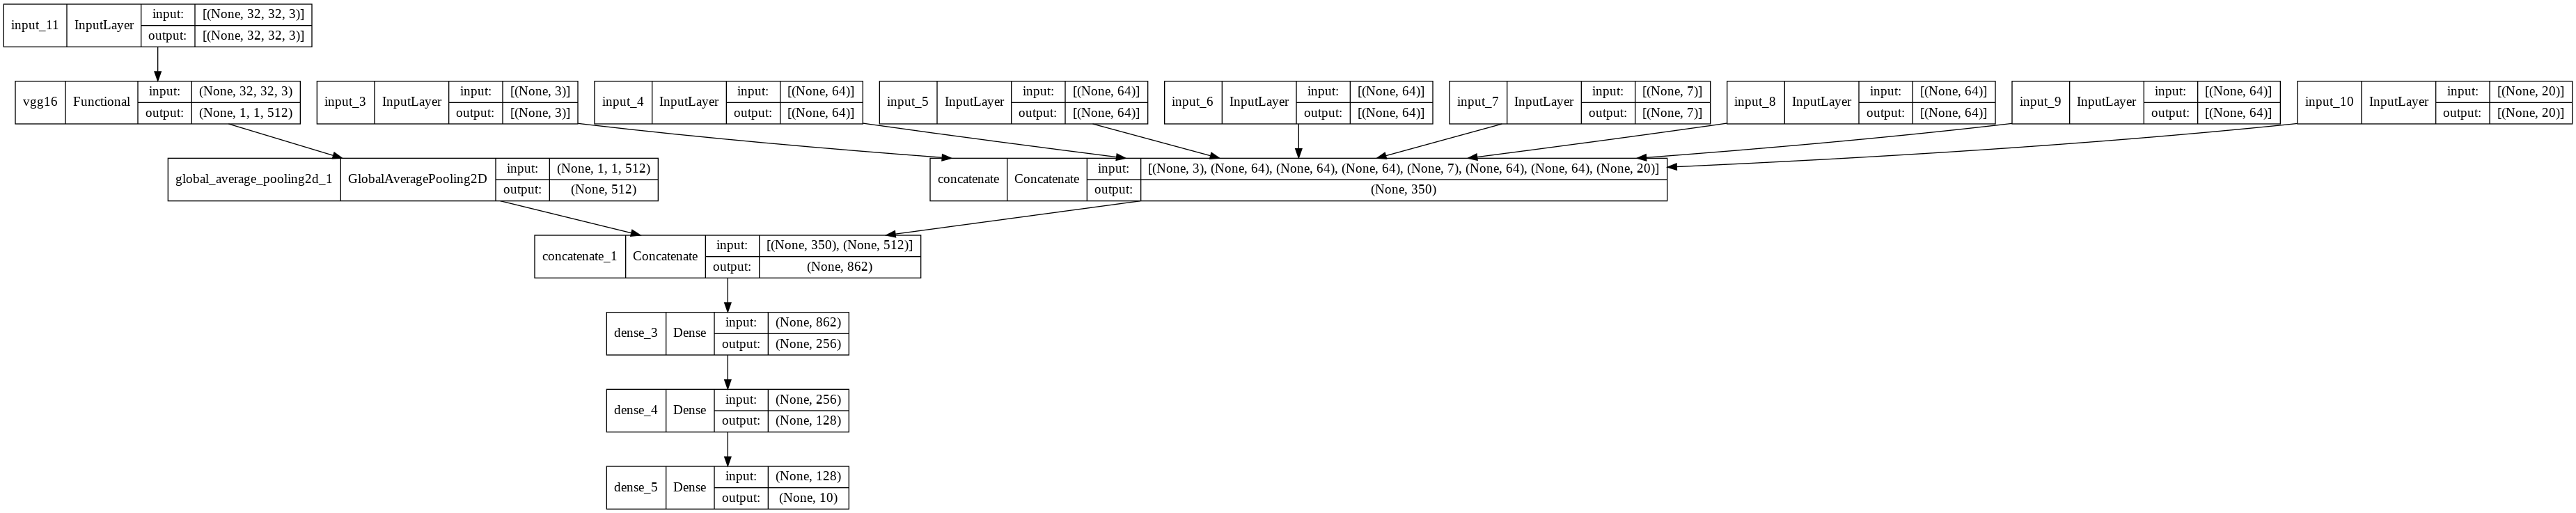

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

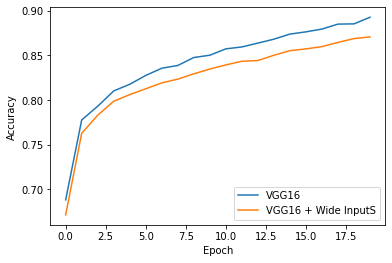

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## VGG16 256Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8868

In [ ]:
VGG16WIDE256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE256_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 39s 117ms/step - loss: 0.9008 - accuracy: 0.6762 - val_loss: 0.7095 - val_accuracy: 0.7339
Epoch 2/20
338/338 [==============================] - 39s 115ms/step - loss: 0.6378 - accuracy: 0.7696 - val_loss: 0.5969 - val_accuracy: 0.7872
Epoch 3/20
338/338 [==============================] - 39s 115ms/step - loss: 0.5783 - accuracy: 0.7948 - val_loss: 0.6075 - val_accuracy: 0.7846
Epoch 4/20
338/338 [==============================] - 39s 115ms/step - loss: 0.5478 - accuracy: 0.8033 - val_loss: 0.5391 - val_accuracy: 0.8119
Epoch 5/20
338/338 [==============================] - 37s 109ms/step - loss: 0.5164 - accuracy: 0.8151 - val_loss: 0.5937 - val_accuracy: 0.7917
Epoch 6/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4968 - accuracy: 0.8197 - val_loss: 0.5465 - val_accuracy: 0.8157
Epoch 7/20
338/338 [==============================] - 39s 115ms/step - loss: 0.4765 - accuracy: 0.8281 - val_loss: 0.5199 - val_ac

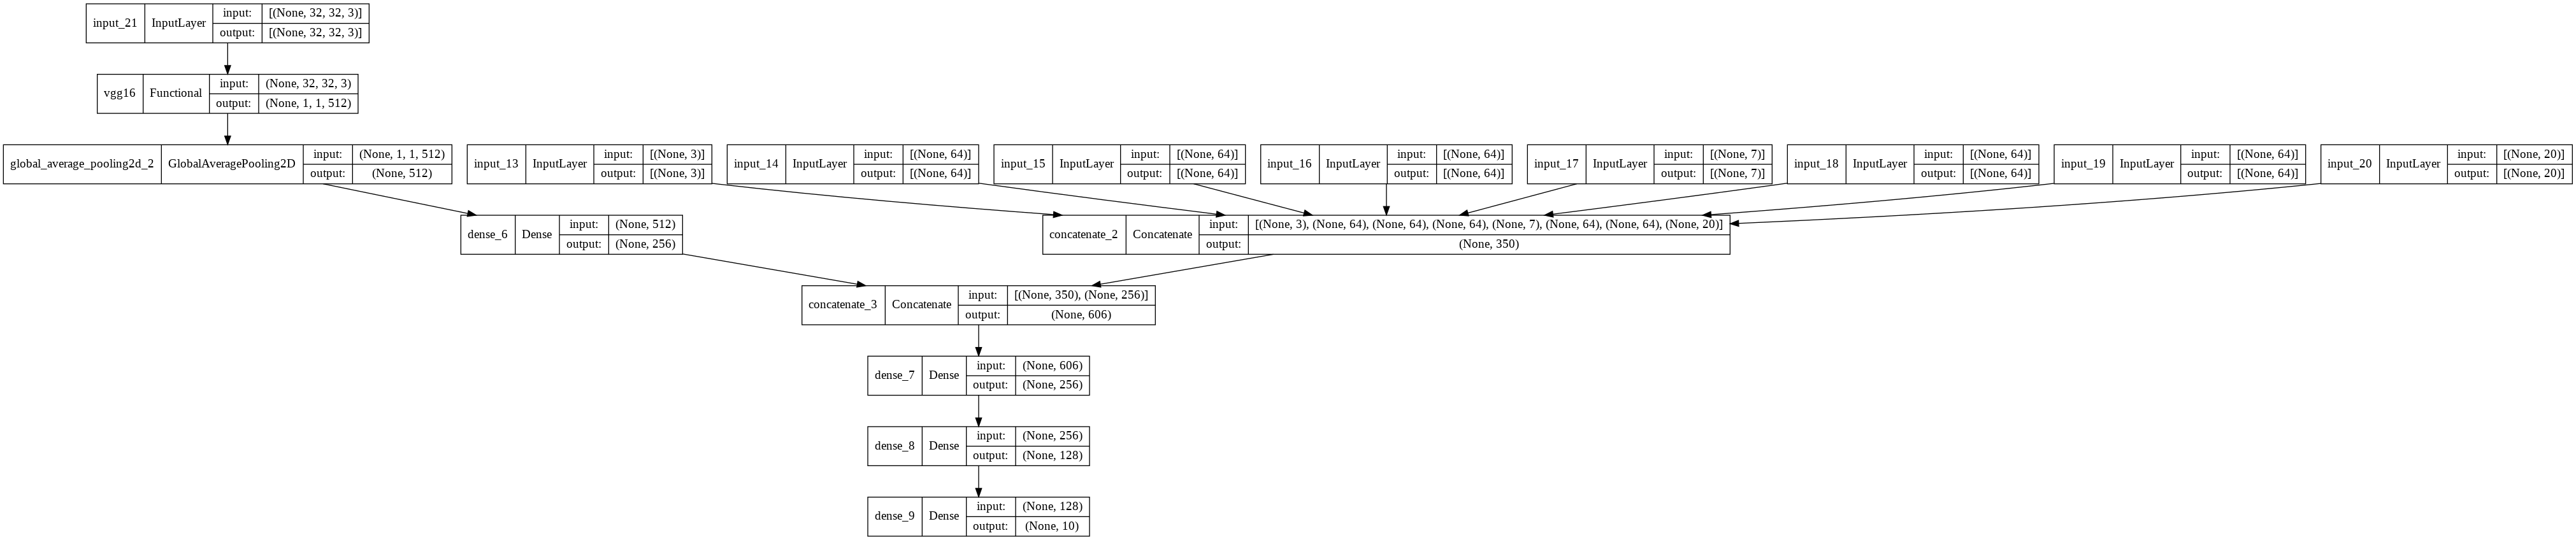

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE256_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

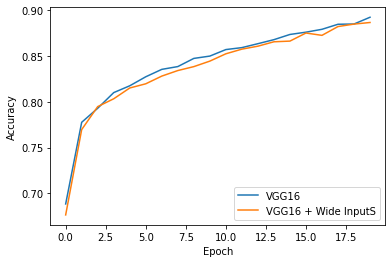

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## VGG16 128Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 2 Dense Layers before softmax.
- Max Accuracy is 0.8880

In [ ]:
VGG16WIDE128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=128, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

VGG16WIDE128_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                       ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                     ]

history_VGG16WIDE128 = VGG16WIDE128_model.fit(GLCMdata_trainMerged, 
                                              y_train,
                                              epochs = epochs,
                                              batch_size = batch_size,
                                              validation_data=(GLCMdata_valMerged, y_test),
                                              #callbacks = [reduce_lr]
                                             )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 38s 112ms/step - loss: 0.9119 - accuracy: 0.6688 - val_loss: 0.7807 - val_accuracy: 0.7252
Epoch 2/20
338/338 [==============================] - 37s 110ms/step - loss: 0.6363 - accuracy: 0.7707 - val_loss: 0.6414 - val_accuracy: 0.7793
Epoch 3/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5909 - accuracy: 0.7912 - val_loss: 0.6584 - val_accuracy: 0.7650
Epoch 4/20
338/338 [==============================] - 39s 116ms/step - loss: 0.5659 - accuracy: 0.8006 - val_loss: 0.5826 - val_accuracy: 0.8020
Epoch 5/20
338/338 [==============================] - 39s 116ms/step - loss: 0.5228 - accuracy: 0.8126 - val_loss: 0.5639 - val_accuracy: 0.8041
Epoch 6/20
338/338 [==============================] - 39s 117ms/step - loss: 0.5016 - accuracy: 0.8204 - val_loss: 0.5900 - val_accuracy: 0.7896
Epoch 7/20
338/338 [==============================] - 37s 110ms/step - loss: 0.4909 - accuracy: 0.8235 - val_loss: 0.5331 - val_ac

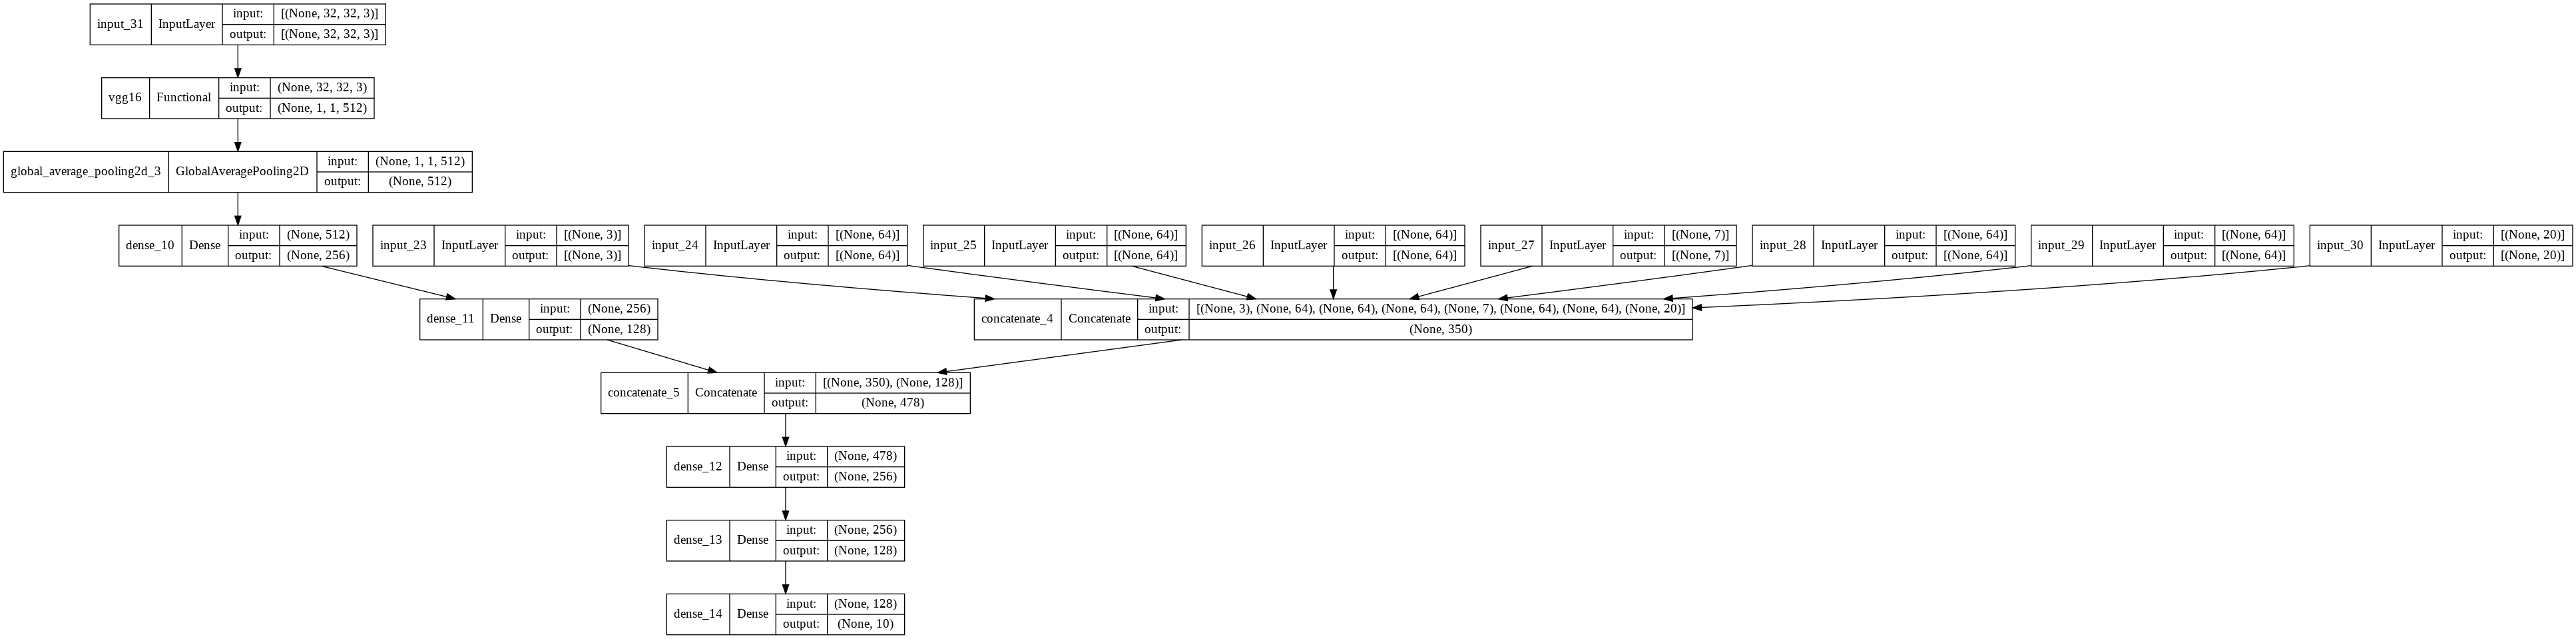

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE128_model, to_file='VGG16WIDE128_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

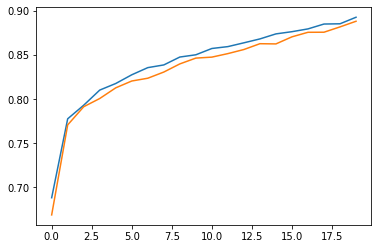

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE128.history['accuracy'])
plt.plot(history_VGG16WIDE256.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 128Inp. + Wide InputS', 'VGG16 256Inp. + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# **ResNet50v2**

In [ ]:
from tensorflow.keras.applications import ResNet50V2

## 1st Experiment

### ResNet50v2 Deep Learning Only
- 20 Epochs
- 3 Dense Layers before softmax.
- Max Accuracy is 0.9793 

In [ ]:
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
predictions = Dense(10, activation= 'softmax')(x)

ResNet50V2_model = Model(inputs = inputs, outputs = predictions)

ResNet50V2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50V2_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                           

In [ ]:
history_ResNet50V2 = ResNet50V2_model.fit(x_train,
                                          y_train,
                                          validation_data=(x_test,y_test), 
                                          batch_size=batch_size,
                                          epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.1846 - accuracy: 0.5901 - val_loss: 1.0752 - val_accuracy: 0.6152
Epoch 2/20
338/338 [==============================] - 69s 205ms/step - loss: 0.9345 - accuracy: 0.6689 - val_loss: 1.0309 - val_accuracy: 0.6402
Epoch 3/20
338/338 [==============================] - 70s 206ms/step - loss: 0.7996 - accuracy: 0.7154 - val_loss: 1.0444 - val_accuracy: 0.6504
Epoch 4/20
338/338 [==============================] - 69s 204ms/step - loss: 0.6818 - accuracy: 0.7564 - val_loss: 1.0984 - val_accuracy: 0.6493
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.5678 - accuracy: 0.7982 - val_loss: 1.2903 - val_accuracy: 0.6402
Epoch 6/20
338/338 [==============================] - 69s 203ms/step - loss: 0.4760 - accuracy: 0.8331 - val_loss: 1.3491 - val_accuracy: 0.6493
Epoch 7/20
338/338 [==============================] - 69s 205ms/step - loss: 0.3782 - accuracy: 0.8700 - val_loss: 1.4875 - val_ac

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input

In [ ]:
ResNet50V2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

ResNet50V2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
ResNet50V2WIDE_model.summary()

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE = ResNet50V2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
ResNet50V2WIDE_model, to_file='modelRES.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 3 Dense Layers before softmax.
- Max Accuracy is 0.9227

In [ ]:
ResNet50V2WIDE_2048_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_2048_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_2048_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_2048 = ResNet50V2WIDE_2048_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 71s 209ms/step - loss: 1.2190 - accuracy: 0.5714 - val_loss: 1.0829 - val_accuracy: 0.6126
Epoch 2/20
338/338 [==============================] - 68s 201ms/step - loss: 0.9988 - accuracy: 0.6450 - val_loss: 1.0165 - val_accuracy: 0.6406
Epoch 3/20
338/338 [==============================] - 71s 209ms/step - loss: 0.9097 - accuracy: 0.6794 - val_loss: 1.0450 - val_accuracy: 0.6409
Epoch 4/20
338/338 [==============================] - 71s 209ms/step - loss: 0.8318 - accuracy: 0.7072 - val_loss: 1.0683 - val_accuracy: 0.6409
Epoch 5/20
338/338 [==============================] - 69s 203ms/step - loss: 0.7599 - accuracy: 0.7326 - val_loss: 1.0703 - val_accuracy: 0.6450
Epoch 6/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6992 - accuracy: 0.7513 - val_loss: 1.0562 - val_accuracy: 0.6572
Epoch 7/20
338/338 [==============================] - 68s 202ms/step - loss: 0.6454 - accuracy: 0.7711 - val_loss: 1.1240 - val_ac

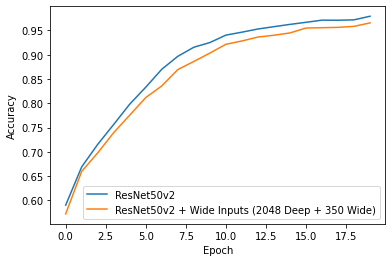

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (2048 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

### ResNet50v2 1024 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 4 Dense Layers before softmax.
- Max Accuracy is 0.9656

In [ ]:
ResNet50V2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_1024 = ResNet50V2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.2055 - accuracy: 0.5721 - val_loss: 1.0758 - val_accuracy: 0.6176
Epoch 2/20
338/338 [==============================] - 67s 197ms/step - loss: 0.9710 - accuracy: 0.6597 - val_loss: 1.0476 - val_accuracy: 0.6369
Epoch 3/20
338/338 [==============================] - 69s 203ms/step - loss: 0.8492 - accuracy: 0.6978 - val_loss: 1.0043 - val_accuracy: 0.6554
Epoch 4/20
338/338 [==============================] - 67s 197ms/step - loss: 0.7374 - accuracy: 0.7396 - val_loss: 1.0520 - val_accuracy: 0.6581
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.6357 - accuracy: 0.7756 - val_loss: 1.1089 - val_accuracy: 0.6498
Epoch 6/20
338/338 [==============================] - 67s 198ms/step - loss: 0.5300 - accuracy: 0.8118 - val_loss: 1.2404 - val_accuracy: 0.6431
Epoch 7/20
338/338 [==============================] - 68s 200ms/step - loss: 0.4606 - accuracy: 0.8357 - val_loss: 1.2536 - val_ac

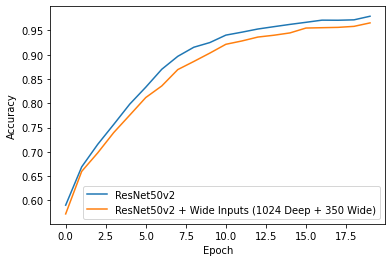

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (1024 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

### ResNet50v2 512 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 4 Dense Layers before softmax.
- Max Accuracy is 0.xx

In [ ]:
ResNet50V2WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_512 = ResNet50V2WIDE_512_model.fit(GLCMdata_trainMerged, 
                                                          y_train,
                                                          epochs = epochs,
                                                          batch_size = batch_size,
                                                          validation_data=(GLCMdata_valMerged, y_test)
                                                          )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 72s 212ms/step - loss: 1.2114 - accuracy: 0.5742 - val_loss: 1.0434 - val_accuracy: 0.6280
Epoch 2/20
338/338 [==============================] - 71s 211ms/step - loss: 0.9603 - accuracy: 0.6600 - val_loss: 1.0091 - val_accuracy: 0.6426
Epoch 3/20
338/338 [==============================] - 71s 211ms/step - loss: 0.8446 - accuracy: 0.6993 - val_loss: 1.0172 - val_accuracy: 0.6424
Epoch 4/20
338/338 [==============================] - 71s 211ms/step - loss: 0.7496 - accuracy: 0.7350 - val_loss: 0.9967 - val_accuracy: 0.6533
Epoch 5/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6551 - accuracy: 0.7667 - val_loss: 1.0864 - val_accuracy: 0.6406
Epoch 6/20
338/338 [==============================] - 69s 204ms/step - loss: 0.5638 - accuracy: 0.8020 - val_loss: 1.1179 - val_accuracy: 0.6470
Epoch 7/20
338/338 [==============================] - 71s 210ms/step - loss: 0.4857 - accuracy: 0.8289 - val_loss: 1.2404 - val_ac

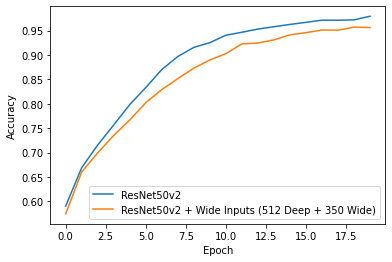

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (512 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

## 2nd Experiment

### ResNet50v2 Deep Learning Only
- 20 Epochs
- 1 Dense Layer before softmax.
- 0.2 Dropout is added. 2times
- Max Accuracy is 0.

In [ ]:
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))

# Warm up model
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
  
inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x=Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(10, activation= 'softmax')(x)

ResNet50V2_model = Model(inputs = inputs, outputs = predictions)

ResNet50V2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50V2_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_20 (Dense)            (None, 512)               524800    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                           

In [ ]:
history_ResNet50V2_Exp2 = ResNet50V2_model.fit(x_train,
                                              y_train,
                                              validation_data=(x_test,y_test), 
                                              batch_size=batch_size,
                                              epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 67s 199ms/step - loss: 1.1846 - accuracy: 0.5901 - val_loss: 1.0752 - val_accuracy: 0.6152
Epoch 2/20
338/338 [==============================] - 69s 205ms/step - loss: 0.9345 - accuracy: 0.6689 - val_loss: 1.0309 - val_accuracy: 0.6402
Epoch 3/20
338/338 [==============================] - 70s 206ms/step - loss: 0.7996 - accuracy: 0.7154 - val_loss: 1.0444 - val_accuracy: 0.6504
Epoch 4/20
338/338 [==============================] - 69s 204ms/step - loss: 0.6818 - accuracy: 0.7564 - val_loss: 1.0984 - val_accuracy: 0.6493
Epoch 5/20
338/338 [==============================] - 66s 196ms/step - loss: 0.5678 - accuracy: 0.7982 - val_loss: 1.2903 - val_accuracy: 0.6402
Epoch 6/20
338/338 [==============================] - 69s 203ms/step - loss: 0.4760 - accuracy: 0.8331 - val_loss: 1.3491 - val_accuracy: 0.6493
Epoch 7/20
338/338 [==============================] - 69s 205ms/step - loss: 0.3782 - accuracy: 0.8700 - val_loss: 1.4875 - val_ac

### ResNet50v2 2048 Param Deep Input + 350 Param Wide Input
- 20 Epochs
- 1 Dense Layer before softmax.
- 0.2 Dropout is added. 2times
- Max Accuracy is 0.

In [ ]:
ResNet50V2WIDE_2048_model_Exp2 = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

ResNet50V2WIDE_2048_model_Exp2 = tf.keras.Model(inputs=[wideInput0, 
                                          wideInputInvariantRed,
                                          wideInputInvariantGreen,
                                          wideInputInvariantBlue, 
                                          wideInputHU,
                                          wideInputHOG,
                                          wideInputLPB,
                                          wideInputGLCM, 
                                          wideInputD
                                          ],  
                                          outputs=merged_out)

ResNet50V2WIDE_2048_model_Exp2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_2048_model_Exp2 = ResNet50V2WIDE_2048_model_Exp2.fit(
                                                          GLCMdata_trainMerged, 
                                                          y_train,
                                                          epochs = epochs,
                                                          batch_size = batch_size,
                                                          validation_data=(GLCMdata_valMerged, y_test)
                                                          )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
338/338 [==============================] - 72s 212ms/step - loss: 1.2114 - accuracy: 0.5742 - val_loss: 1.0434 - val_accuracy: 0.6280
Epoch 2/20
338/338 [==============================] - 71s 211ms/step - loss: 0.9603 - accuracy: 0.6600 - val_loss: 1.0091 - val_accuracy: 0.6426
Epoch 3/20
338/338 [==============================] - 71s 211ms/step - loss: 0.8446 - accuracy: 0.6993 - val_loss: 1.0172 - val_accuracy: 0.6424
Epoch 4/20
338/338 [==============================] - 71s 211ms/step - loss: 0.7496 - accuracy: 0.7350 - val_loss: 0.9967 - val_accuracy: 0.6533
Epoch 5/20
338/338 [==============================] - 68s 201ms/step - loss: 0.6551 - accuracy: 0.7667 - val_loss: 1.0864 - val_accuracy: 0.6406
Epoch 6/20
338/338 [==============================] - 69s 204ms/step - loss: 0.5638 - accuracy: 0.8020 - val_loss: 1.1179 - val_accuracy: 0.6470
Epoch 7/20
338/338 [==============================] - 71s 210ms/step - loss: 0.4857 - accuracy: 0.8289 - val_loss: 1.2404 - val_ac

In [ ]:
plt.plot(history_ResNet50V2_Exp2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_2048_model_Exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs (512 Deep + 350 Wide)'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

# **DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121

## 1st Experiment

### DenseNet121 DL Only
- 2 Dense Layers
- 1 Dropout with 0.2 and 1 Batch Normalization
- The max accuracy is 0.92??

In [ ]:
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))

base_model.trainable = False

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

DenseNet121_model = Model(inputs = inputs, outputs = predictions)

DenseNet121_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_10  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                            

In [ ]:
history_DenseNet121 = DenseNet121_model.fit( x_train,y_train,
                                               validation_data = (x_test,y_test),
                                               epochs=20
                                               #callbacks=[reduce_lr]
                                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 256s 379ms/step - loss: 0.7562 - accuracy: 0.7425 - val_loss: 0.6493 - val_accuracy: 0.7798
Epoch 2/20
675/675 [==============================] - 260s 385ms/step - loss: 0.5781 - accuracy: 0.7969 - val_loss: 0.5263 - val_accuracy: 0.8191
Epoch 3/20
675/675 [==============================] - 264s 391ms/step - loss: 0.5192 - accuracy: 0.8184 - val_loss: 0.5383 - val_accuracy: 0.8130
Epoch 4/20
675/675 [==============================] - 274s 405ms/step - loss: 0.4848 - accuracy: 0.8278 - val_loss: 0.5392 - val_accuracy: 0.8137
Epoch 5/20
675/675 [==============================] - 265s 393ms/step - loss: 0.4584 - accuracy: 0.8346 - val_loss: 0.5257 - val_accuracy: 0.8135
Epoch 6/20
675/675 [==============================] - 275s 407ms/step - loss: 0.4269 - accuracy: 0.8483 - val_loss: 0.5310 - val_accuracy: 0.8156
Epoch 7/20
675/675 [==============================] - 269s 398ms/step - loss: 0.4035 - accuracy: 0.8561 - val_loss: 0.5539 -

### DenseNet121 1024Param Deep Input + 350 Param Wide Input
- 2 Dense Layers
- 1 Dropout with 0.2 and 1 Batch Normalization
- The max accuracy is 0.9???

In [ ]:
DenseNet121WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = Dense(512,activation='relu')(x)
merged_out = BatchNormalization()(merged_out)
merged_out = Dropout(0.2)(merged_out)
merged_out = Dense(256,activation='relu')(merged_out)
merged_out = Dense(CLASS_NUMBER, activation= 'softmax')(merged_out)

DenseNet121WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                      wideInputInvariantRed,
                                      wideInputInvariantGreen,
                                      wideInputInvariantBlue, 
                                      wideInputHU,
                                      wideInputHOG,
                                      wideInputLPB,
                                      wideInputGLCM, 
                                      wideInputD
                                      ],  
                                      outputs=merged_out)

DenseNet121WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE = DenseNet121WIDE_model.fit(GLCMdata_trainMerged, 
                                                    y_train,
                                                    epochs = epochs,
                                                    validation_data=(GLCMdata_valMerged, y_test),
                                                    #callbacks = [reduce_lr]
                                                    )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 169s 376ms/step - loss: 0.2521 - accuracy: 0.8953 - val_loss: 0.2232 - val_accuracy: 0.9094
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.1576 - val_accuracy: 0.9371
Epoch 3/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 5/20
450/450 [==============================] - 166s 369ms/step - loss: 0.1113 - accuracy: 0.9576 - val_loss: 0.1543 - val_accuracy: 0.9465
Epoch 6/20
450/450 [==============================] - 167s 371ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0933 - accuracy: 0.9633 - val_loss: 0.1418 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_model, to_file='modeleff.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['EfficientNetB0', 'EfficientNetB0 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## 2nd Experiment

### DenseNet121 DL Only

In [ ]:

from tensorflow.keras.applications import DenseNet121

base_model_exp2 = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model_exp2.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model_exp2 is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model_exp2(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

DenseNet121_model_exp2 = Model(inputs = inputs, outputs = predictions)

DenseNet121_model_exp2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model_exp2.summary()

NameError: ignored

In [ ]:
history_DenseNet121_model_exp2 = DenseNet121_model_exp2.fit( x_train,y_train,
                                               validation_data=(x_test,y_test),
                                               epochs=20,
                                               batch_size = batch_size
                                               #callbacks=[reduce_lr]
                                              )

### DenseNet121 512Param Deep Input + 350 Param Wide Input


In [ ]:
from tensorflow.keras.applications import DenseNet121

DenseNet121WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])

merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

DenseNet121WIDE_512_model = tf.keras.Model( inputs=[wideInput0, 
                                            wideInputInvariantRed,
                                            wideInputInvariantGreen,
                                            wideInputInvariantBlue, 
                                            wideInputHU,
                                            wideInputHOG,
                                            wideInputLPB,
                                            wideInputGLCM, 
                                            wideInputD
                                            ],  
                                            outputs=merged_out)

DenseNet121WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE_512 = DenseNet121WIDE_512_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 20,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 169s 376ms/step - loss: 0.2521 - accuracy: 0.8953 - val_loss: 0.2232 - val_accuracy: 0.9094
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.1576 - val_accuracy: 0.9371
Epoch 3/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 5/20
450/450 [==============================] - 166s 369ms/step - loss: 0.1113 - accuracy: 0.9576 - val_loss: 0.1543 - val_accuracy: 0.9465
Epoch 6/20
450/450 [==============================] - 167s 371ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0933 - accuracy: 0.9633 - val_loss: 0.1418 -

### Result Comparisons

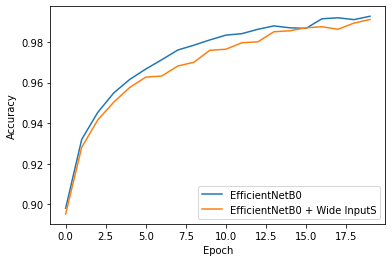

In [ ]:
plt.plot(history_DenseNet121_model_exp2.history['accuracy'])
plt.plot(history_DenseNet121WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'DenseNet121 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# **MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

## 1st Experiment

### MobileNetv2 Deep Inputs Only
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.7595

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
#x = layers.Flatten()(x)
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(CLASS_NUMBER, activation= 'softmax')(x)

MobileNetV2_model = Model(inputs = inputs, outputs = predictions)

MobileNetV2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNetV2_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                

In [ ]:
history_MobileNetV2 = MobileNetV2_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=epochs,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 178ms/step - loss: 1.2685 - accuracy: 0.5421 - val_loss: 1.1391 - val_accuracy: 0.5820
Epoch 2/20
675/675 [==============================] - 119s 177ms/step - loss: 1.1277 - accuracy: 0.5927 - val_loss: 1.0728 - val_accuracy: 0.6102
Epoch 3/20
675/675 [==============================] - 120s 177ms/step - loss: 1.0783 - accuracy: 0.6077 - val_loss: 1.0815 - val_accuracy: 0.6013
Epoch 4/20
675/675 [==============================] - 119s 176ms/step - loss: 1.0410 - accuracy: 0.6229 - val_loss: 1.0434 - val_accuracy: 0.6244
Epoch 5/20
675/675 [==============================] - 120s 178ms/step - loss: 1.0096 - accuracy: 0.6331 - val_loss: 1.0527 - val_accuracy: 0.6219
Epoch 6/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9812 - accuracy: 0.6431 - val_loss: 1.0633 - val_accuracy: 0.6202
Epoch 7/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9525 - accuracy: 0.6513 - val_loss: 1.0850 -

### MobileNetv2 1280 Param Deep Input + 350 Param Wide Input
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.6841

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
#merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=CLASS_NUMBER, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 189ms/step - loss: 1.4084 - accuracy: 0.4812 - val_loss: 1.2656 - val_accuracy: 0.5306
Epoch 2/20
675/675 [==============================] - 128s 190ms/step - loss: 1.2248 - accuracy: 0.5565 - val_loss: 1.1411 - val_accuracy: 0.5881
Epoch 3/20
675/675 [==============================] - 123s 183ms/step - loss: 1.1700 - accuracy: 0.5727 - val_loss: 1.1042 - val_accuracy: 0.5991
Epoch 4/20
675/675 [==============================] - 128s 190ms/step - loss: 1.1267 - accuracy: 0.5944 - val_loss: 1.0774 - val_accuracy: 0.6169
Epoch 5/20
675/675 [==============================] - 129s 191ms/step - loss: 1.0919 - accuracy: 0.6073 - val_loss: 1.0166 - val_accuracy: 0.6357
Epoch 6/20
675/675 [==============================] - 129s 191ms/step - loss: 1.0710 - accuracy: 0.6164 - val_loss: 1.0455 - val_accuracy: 0.6311
Epoch 7/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0358 - accuracy: 0.6285 - val_loss: 1.0268 -

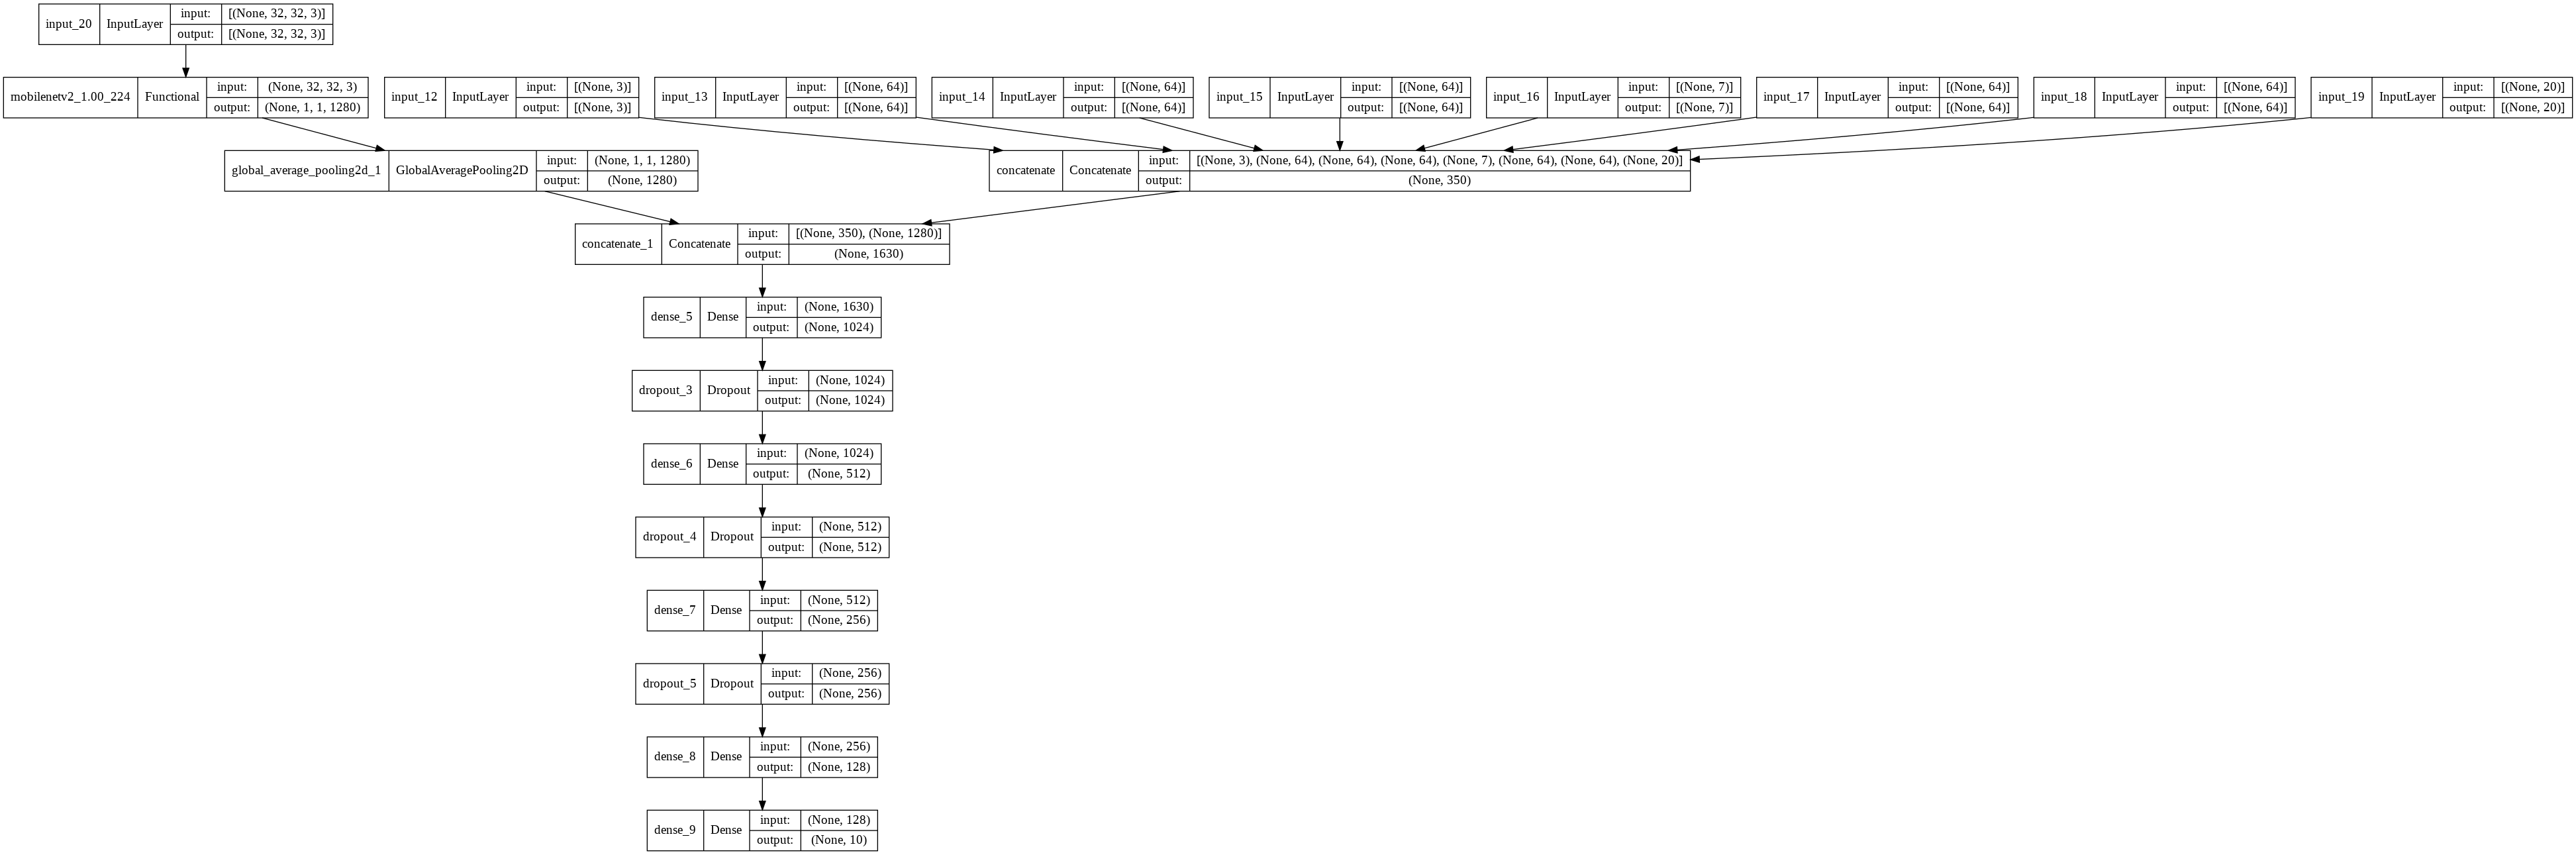

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

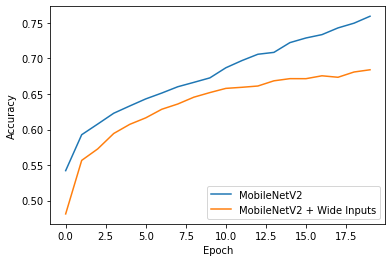

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 1024 Param Deep Input + 350 Param Wide Input
- 3 Dropout layers just before the prediction layer.
- Max accuracy 0.7643

In [ ]:
MobileNetV2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_1024_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_40[0][0]']               
 al)                                                                                              
                                                                                                  
 input_32 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 64)]         0           []                         

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_1024 = MobileNetV2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 125s 185ms/step - loss: 1.3475 - accuracy: 0.5137 - val_loss: 1.1809 - val_accuracy: 0.5813
Epoch 2/20
675/675 [==============================] - 124s 183ms/step - loss: 1.1742 - accuracy: 0.5818 - val_loss: 1.1012 - val_accuracy: 0.6070
Epoch 3/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1169 - accuracy: 0.5984 - val_loss: 1.0770 - val_accuracy: 0.6094
Epoch 4/20
675/675 [==============================] - 130s 192ms/step - loss: 1.0780 - accuracy: 0.6139 - val_loss: 1.0672 - val_accuracy: 0.6217
Epoch 5/20
675/675 [==============================] - 129s 192ms/step - loss: 1.0424 - accuracy: 0.6242 - val_loss: 1.0867 - val_accuracy: 0.6170
Epoch 6/20
675/675 [==============================] - 123s 182ms/step - loss: 1.0205 - accuracy: 0.6348 - val_loss: 1.0453 - val_accuracy: 0.6293
Epoch 7/20
675/675 [==============================] - 129s 191ms/step - loss: 0.9867 - accuracy: 0.6455 - val_loss: 1.0430 -

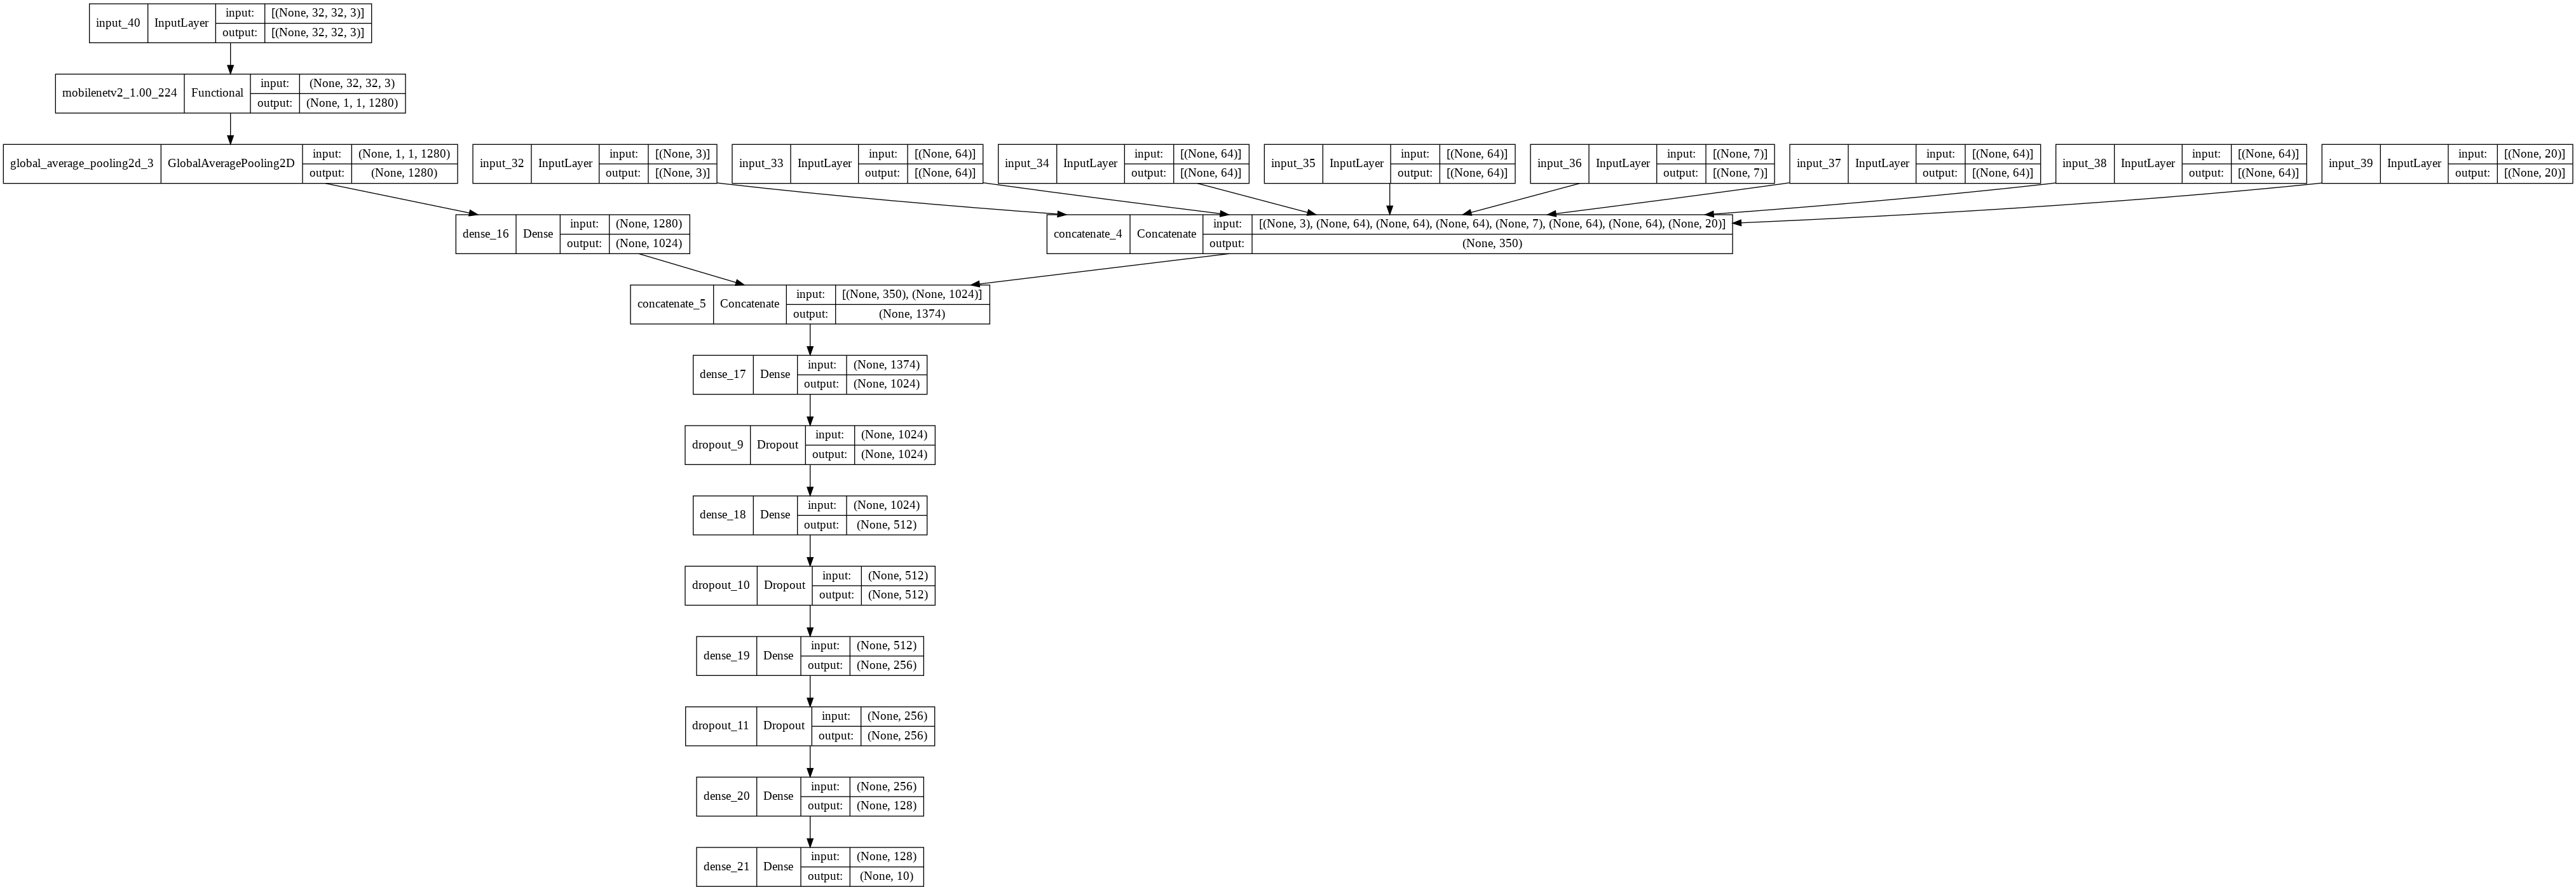

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

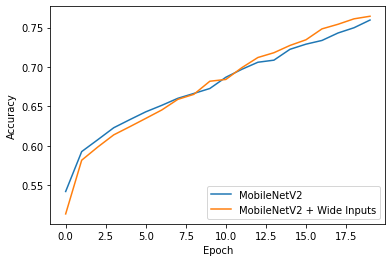

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 512 Param Deep Input + 350 Param Wide Input
- **3** Dropout layers just before the prediction layer.
- Max accuracy 0.7835

In [ ]:
MobileNetV2WIDE_512_model3 = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_512_model3 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_512_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
MobileNetV2WIDE_512_model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_18[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_512_3 = MobileNetV2WIDE_512_model3.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
159/675 [======>.......................] - ETA: 59s - loss: 0.6102 - accuracy: 0.7801

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_512_3.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

NameError: ignored

### MobileNetv2 512 Param Deep Input + 350 Param Wide Input
- 2 Dropout layers just before the prediction layer.
- Max accuracy 0.8342

In [ ]:
MobileNetV2WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_512_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_60[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_5 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_512 = MobileNetV2WIDE_512_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 130s 192ms/step - loss: 1.3312 - accuracy: 0.5154 - val_loss: 1.1543 - val_accuracy: 0.5865
Epoch 2/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1560 - accuracy: 0.5845 - val_loss: 1.1383 - val_accuracy: 0.5926
Epoch 3/20
675/675 [==============================] - 125s 185ms/step - loss: 1.0923 - accuracy: 0.6105 - val_loss: 1.1143 - val_accuracy: 0.6057
Epoch 4/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0476 - accuracy: 0.6263 - val_loss: 1.0902 - val_accuracy: 0.6089
Epoch 5/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0219 - accuracy: 0.6337 - val_loss: 1.0710 - val_accuracy: 0.6257
Epoch 6/20
675/675 [==============================] - 124s 184ms/step - loss: 0.9814 - accuracy: 0.6479 - val_loss: 1.0380 - val_accuracy: 0.6252
Epoch 7/20
675/675 [==============================] - 129s 192ms/step - loss: 0.9425 - accuracy: 0.6646 - val_loss: 1.0702 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
history_MobileNetV2WIDE_512, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

AttributeError: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 256 Param Deep Input + 350 Param Wide Input
- No Dropout Layer
- Max accuracy 0.8917

In [ ]:
MobileNetV2WIDE_256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_256_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_80[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_256 = MobileNetV2WIDE_256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 128s 190ms/step - loss: 1.2446 - accuracy: 0.5469 - val_loss: 1.1702 - val_accuracy: 0.5759
Epoch 2/20
675/675 [==============================] - 122s 181ms/step - loss: 1.0908 - accuracy: 0.6062 - val_loss: 1.0834 - val_accuracy: 0.6100
Epoch 3/20
675/675 [==============================] - 122s 181ms/step - loss: 1.0386 - accuracy: 0.6252 - val_loss: 1.0647 - val_accuracy: 0.6200
Epoch 4/20
675/675 [==============================] - 127s 188ms/step - loss: 0.9858 - accuracy: 0.6395 - val_loss: 1.0528 - val_accuracy: 0.6181
Epoch 5/20
675/675 [==============================] - 122s 181ms/step - loss: 0.9451 - accuracy: 0.6539 - val_loss: 1.0493 - val_accuracy: 0.6250
Epoch 6/20
675/675 [==============================] - 121s 179ms/step - loss: 0.9012 - accuracy: 0.6714 - val_loss: 1.0280 - val_accuracy: 0.6357
Epoch 7/20
675/675 [==============================] - 127s 188ms/step - loss: 0.8605 - accuracy: 0.6891 - val_loss: 1.0275 -

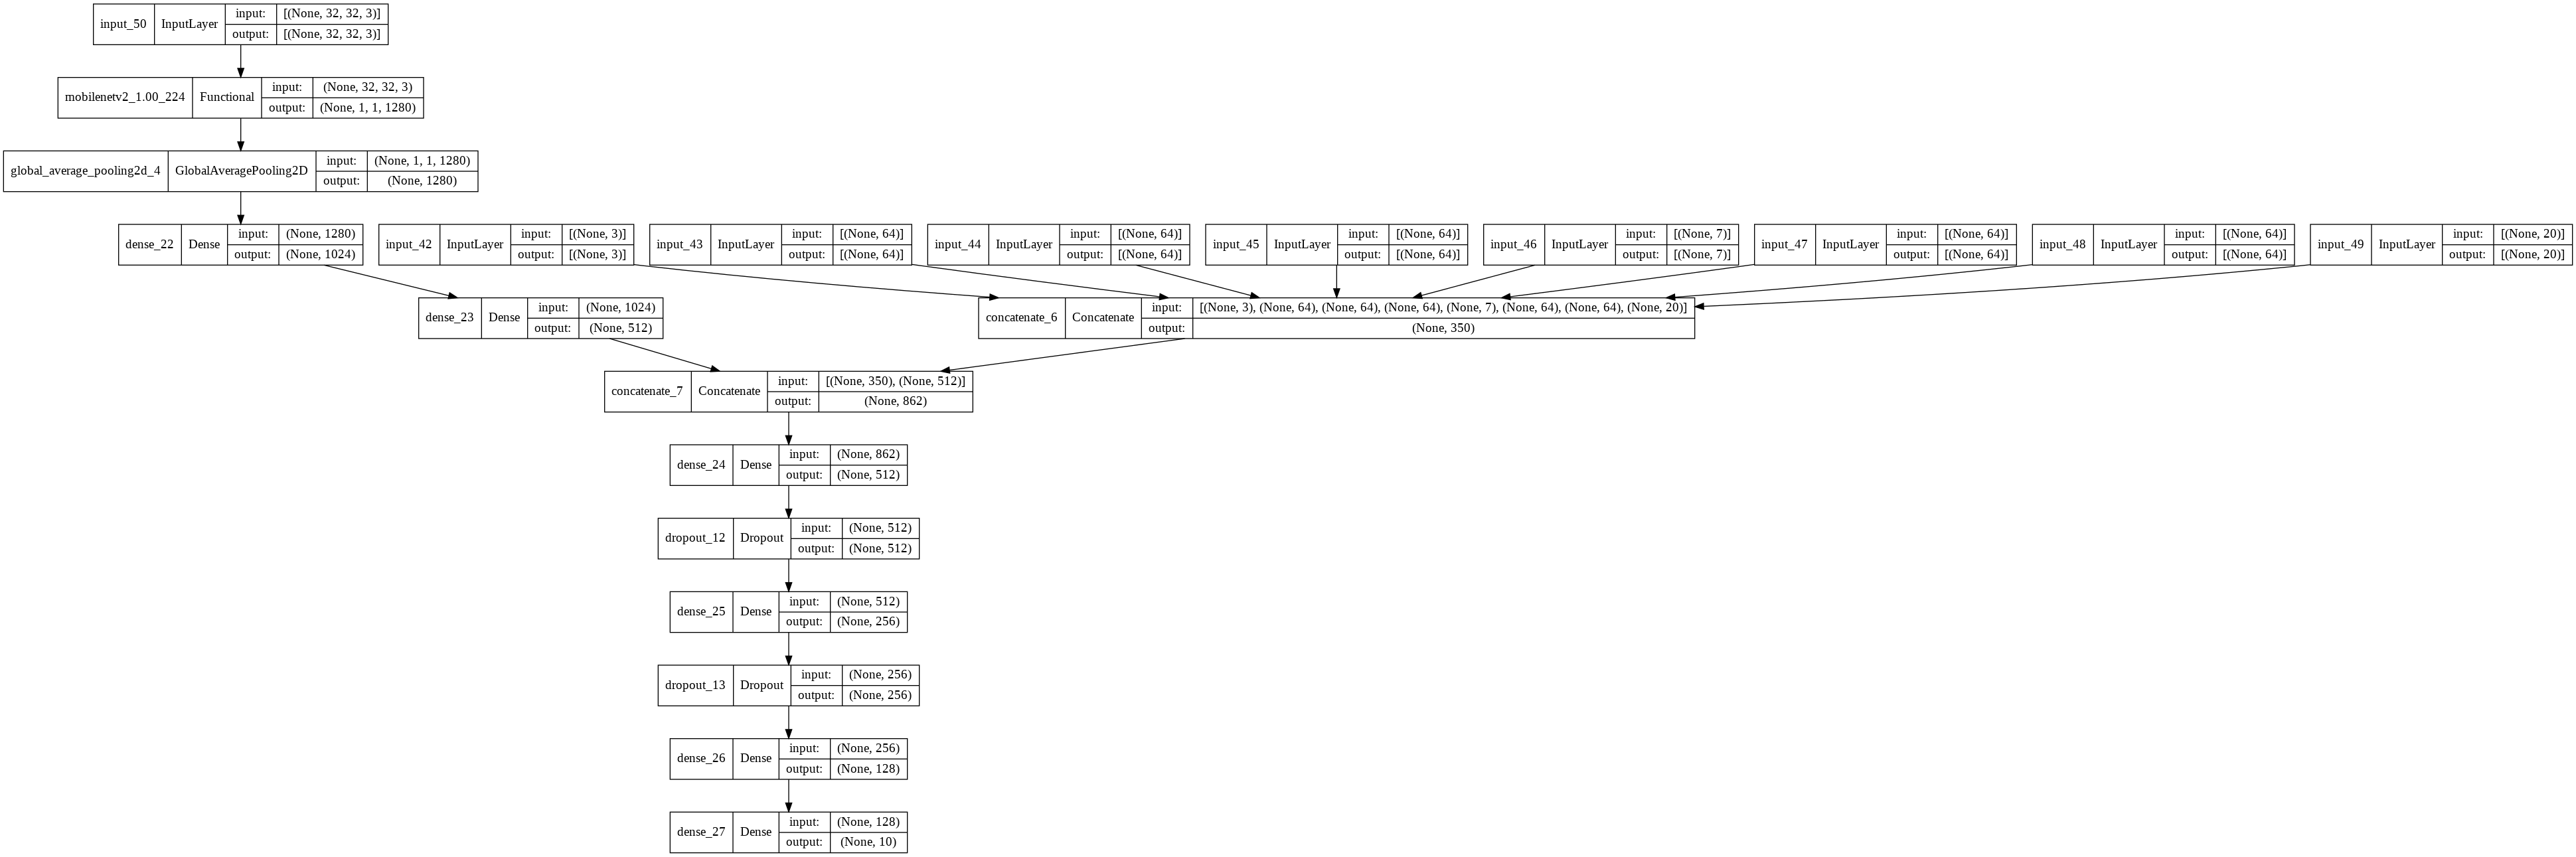

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

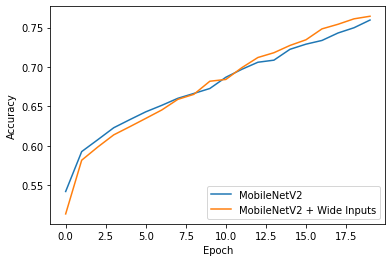

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

### MobileNetv2 256 Param Deep Input + 350 Param Wide Input
- 3 Dropout Layer
- 3 Batch Normalization Layer
- Max accuracy 0.7599

In [ ]:
MobileNetV2WIDE_256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = BatchNormalization()(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_deep = BatchNormalization()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_deep = layers.Dropout(0.2)(merged_deep)
merged_out = BatchNormalization()(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_256_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_38[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_2 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_256 = MobileNetV2WIDE_256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 108s 159ms/step - loss: 1.3034 - accuracy: 0.5324 - val_loss: 1.1337 - val_accuracy: 0.5841
Epoch 2/20
675/675 [==============================] - 99s 146ms/step - loss: 1.1511 - accuracy: 0.5785 - val_loss: 1.1034 - val_accuracy: 0.5967
Epoch 3/20
675/675 [==============================] - 98s 145ms/step - loss: 1.1114 - accuracy: 0.5970 - val_loss: 1.0721 - val_accuracy: 0.6141
Epoch 4/20
675/675 [==============================] - 98s 146ms/step - loss: 1.0792 - accuracy: 0.6063 - val_loss: 1.0817 - val_accuracy: 0.6094
Epoch 5/20
675/675 [==============================] - 108s 159ms/step - loss: 1.0554 - accuracy: 0.6175 - val_loss: 1.0817 - val_accuracy: 0.6076
Epoch 6/20
675/675 [==============================] - 108s 160ms/step - loss: 1.0320 - accuracy: 0.6244 - val_loss: 1.0480 - val_accuracy: 0.6237
Epoch 7/20
675/675 [==============================] - 107s 159ms/step - loss: 1.0118 - accuracy: 0.6322 - val_loss: 1.0599 - va

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

## 2nd Experiment:

### MobileNetV2 2nd Experiment without wide inputs:
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy 0.6902

In [ ]:

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x)
x=Dropout(0.25)(x)
x = BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.25)(x)
x = BatchNormalization()(x)
predictions = Dense(10, activation= 'softmax')(x)

xx_model = Model(inputs = inputs, outputs = predictions)

xx_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
xx_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096

In [ ]:
history_xx_model = xx_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=epochs,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
675/675 [==============================] - 131s 194ms/step - loss: 1.3393 - accuracy: 0.5300 - val_loss: 1.1286 - val_accuracy: 0.5822
Epoch 2/20
675/675 [==============================] - 129s 191ms/step - loss: 1.1608 - accuracy: 0.5799 - val_loss: 1.0907 - val_accuracy: 0.6061
Epoch 3/20
675/675 [==============================] - 125s 186ms/step - loss: 1.1116 - accuracy: 0.5912 - val_loss: 1.0748 - val_accuracy: 0.6100
Epoch 4/20
675/675 [==============================] - 123s 182ms/step - loss: 1.0759 - accuracy: 0.6031 - val_loss: 1.0814 - val_accuracy: 0.6094
Epoch 5/20
675/675 [==============================] - 121s 180ms/step - loss: 1.0596 - accuracy: 0.6093 - val_loss: 1.0629 - val_accuracy: 0.6204
Epoch 6/20
675/675 [==============================] - 124s 184ms/step - loss: 1.0343 - accuracy: 0.6241 - val_loss: 1.0590 - val_accuracy: 0.6159
Epoch 7/20
675/675 [==============================] - 127s 189ms/step - loss: 1.0193 - accuracy: 0.6270 - val_loss: 1.0608 -

### MobileNetv2 with wide inputs:
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy 0.6237

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out =Dense(1024,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out =Dense(256,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 24,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/24
675/675 [==============================] - 132s 196ms/step - loss: 1.5567 - accuracy: 0.4612 - val_loss: 2.0882 - val_accuracy: 0.3293
Epoch 2/24
675/675 [==============================] - 123s 183ms/step - loss: 1.4156 - accuracy: 0.4854 - val_loss: 1.2984 - val_accuracy: 0.5133
Epoch 3/24
675/675 [==============================] - 121s 179ms/step - loss: 1.3375 - accuracy: 0.5209 - val_loss: 1.3041 - val_accuracy: 0.5294
Epoch 4/24
675/675 [==============================] - 120s 178ms/step - loss: 1.2803 - accuracy: 0.5422 - val_loss: 1.1616 - val_accuracy: 0.5861
Epoch 5/24
675/675 [==============================] - 126s 186ms/step - loss: 1.2823 - accuracy: 0.5393 - val_loss: 1.2109 - val_accuracy: 0.5422
Epoch 6/24
675/675 [==============================] - 131s 194ms/step - loss: 1.2244 - accuracy: 0.5647 - val_loss: 1.1257 - val_accuracy: 0.5770
Epoch 7/24
675/675 [==============================] - 129s 191ms/step - loss: 1.1941 - accuracy: 0.5753 - val_loss: 1.2178 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

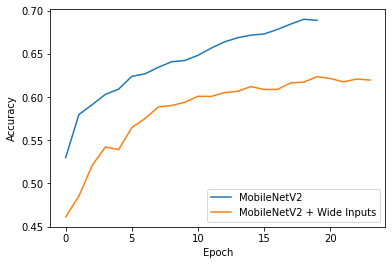

In [ ]:
plt.plot(history_xx_model.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

# **EfficientNetB0**

In [63]:
from tensorflow.keras.applications import EfficientNetB0

## 1st Experiment:

### EfficientNetB0 DL Only
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy xxx

In [186]:
base_model = EfficientNetB0(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False


inputs = tf.keras.Input(shape=(input_shape))
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
#x=Dropout(0.2)(x)
#x = BatchNormalization()(x)
predictions = Dense(10, activation= 'softmax')(x)

xx_model = Model(inputs = inputs, outputs = predictions)

xx_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
xx_model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_20 (Dense)            (None, 512)               655872    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 10)                2570      
                                                          

In [84]:
history_xx_model = xx_model.fit(x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                #callbacks=[reduce_lr]
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
104/675 [===>..........................] - ETA: 1:57 - loss: 2.3255 - accuracy: 0.1130

KeyboardInterrupt: ignored

### EfficientNetB0 with wide inputs:
- 2 Dropout Layer with 0.25 value
- 2 Batch Normalization Layer
- 2 Dense Layer
- Max accuracy xxx

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out =Dense(1024,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out =Dense(256,activation='relu')(merged_out)
merged_out =Dropout(0.25)(merged_out)
merged_out = BatchNormalization()(merged_out)
merged_out = layers.Dense(units=10, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 24,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_xx_model.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')